# imports

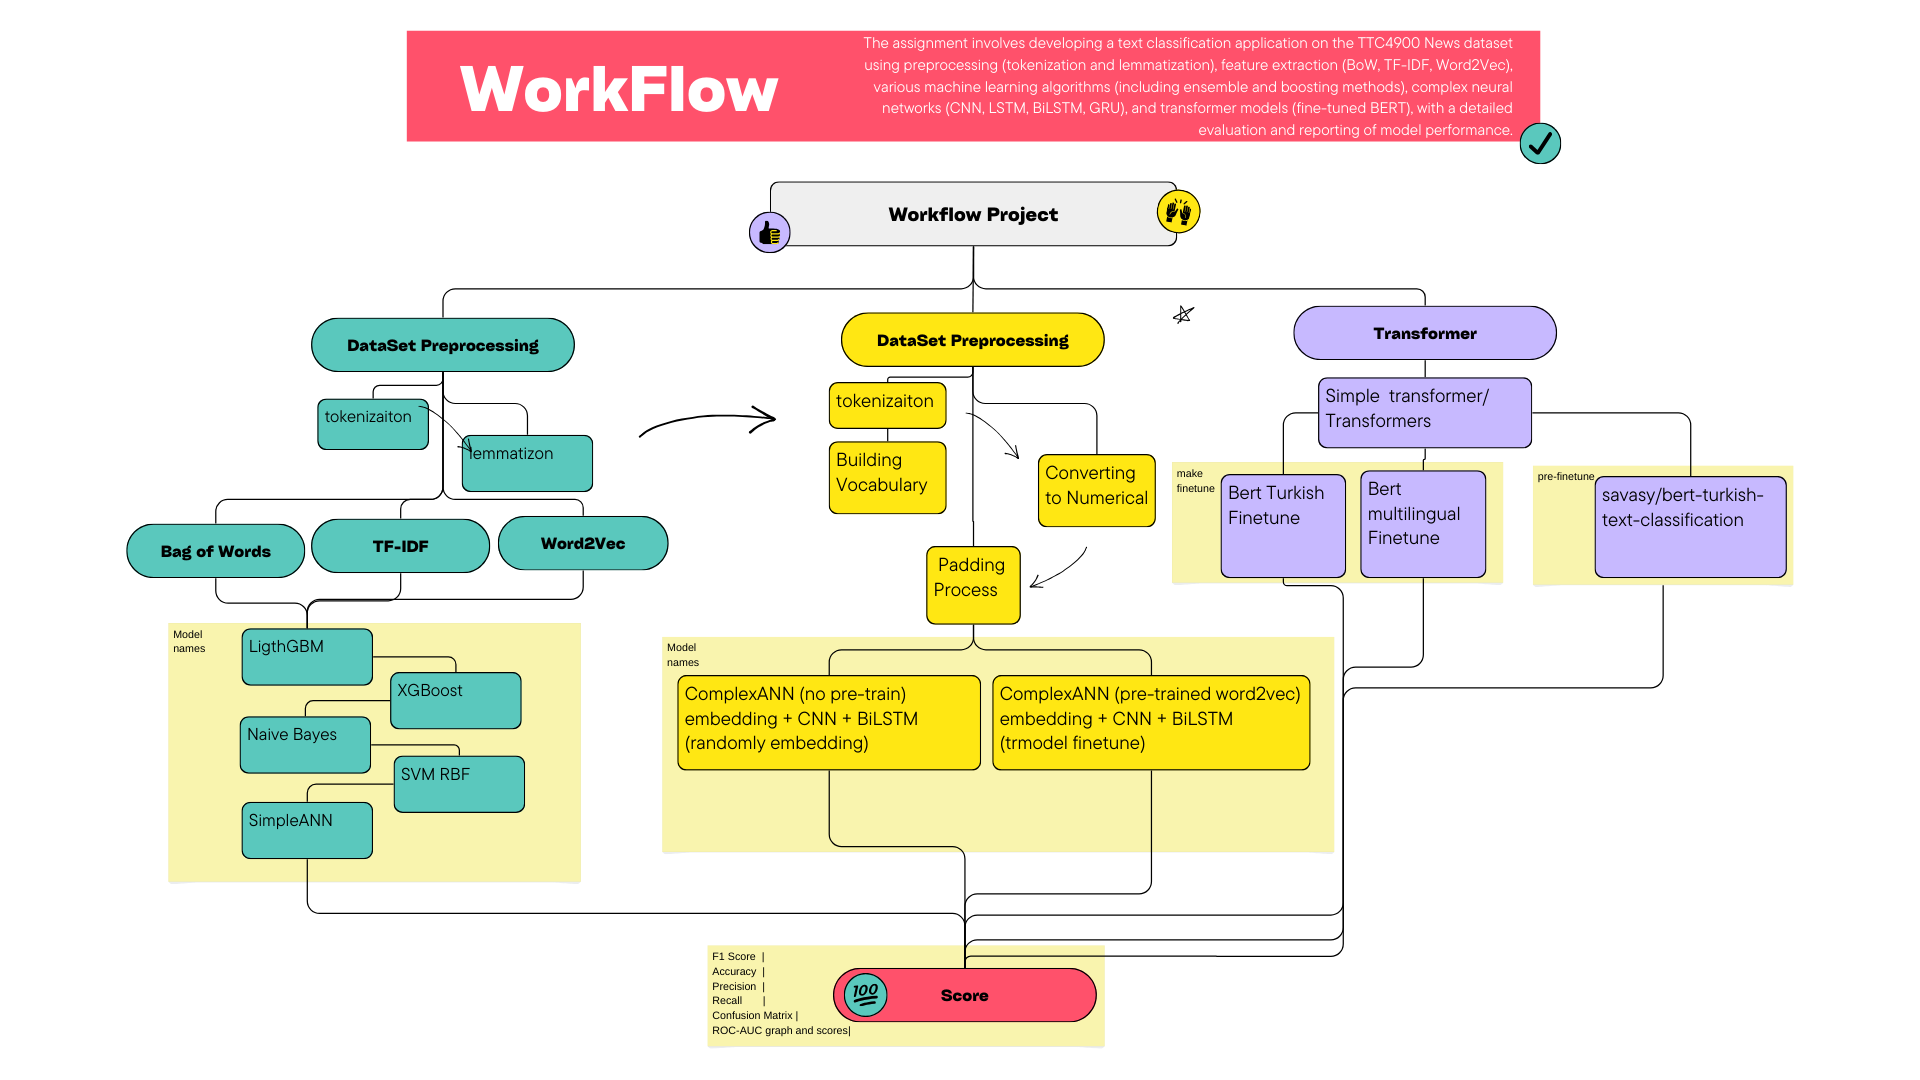

In [3]:
import torch

if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)
else:
    print("CUDA is not available.")

print(torch.cuda.is_available());
print(torch.cuda.device_count());
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU detected')

import torchtext; print('TorchText Version:', torchtext.__version__)

CUDA Version: 12.1
True
1
NVIDIA GeForce RTX 4060 Laptop GPU
TorchText Version: 0.18.0+cpu


In [4]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns 
import re # regular expression libary.
import nltk # Natural Language toolkit
nltk.download("stopwords")  #downloading stopwords
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
nltk.download('wordnet')
import nltk as nlp
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilker\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ilker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ilker\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilker\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load dataset

In [6]:
df_main = pd.read_csv('7allV03.csv', encoding="utf-8-sig")

In [7]:
df_main.sample(10)

,category,text
4069,spor,rumen istilası ! 12 ekim de oynanacak türkiye...
3494,saglik,sıkın korunun amerikan california_üniversites...
3225,saglik,spordan önce kalp muayenesi şart ! sportif fa...
3748,spor,bu kadro başaramaz milli_takım ın bu yapısıyl...
1163,dunya,ürdün de yeni hükümet ürdün_kralı 2 abdullah ...
3832,spor,muratpaşa_belediyesi nden erteleme li zafer h...
3694,spor,gakgoşlar 181 gün sonra 3 puanla tanıştı spor...
529,siyaset,bulgaristan da türk vekile silahlı saldırı bu...
1078,dunya,lübnan da hükümeti boykot kararı lübnan da mu...
4559,teknoloji,ipad mini den sonra sıra onda apple ın ipad m...


In [8]:
df_main.describe()

,category,text
count,4900,4900
unique,7,4539
top,siyaset,messi nin emzik sürpriz bozuldu ! barcelona n...
freq,700,5


In [9]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  4900 non-null   object
 1   text      4900 non-null   object
dtypes: object(2)
memory usage: 76.7+ KB


In [10]:
df_main['category'].value_counts()

category
siyaset       700
dunya         700
ekonomi       700
kultur        700
saglik        700
spor          700
teknoloji     700
Name: count, dtype: int64

In [11]:
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import plotly.io as pio

init_notebook_mode(True)

fig = px.bar(x=df_main.category.value_counts().index,y=df_main.category.value_counts(),
             color=df_main.category.value_counts().index,text=df_main.category.value_counts())

fig.update_traces(hovertemplate="Category:'%{x}' Counted: %{y}")

fig.update_layout(title={"text":"Category Counts","x":0.5,"font":{"size":35}},
                  xaxis={"title":"Category","showgrid":False},yaxis={"title":"Value","showgrid":False},
                  plot_bgcolor="white",width=800,height=500,showlegend=False)
iplot(fig)

In [12]:
fig1 = px.pie(df_main,values=df_main.category.value_counts().values,names=df_main.category.value_counts().index)
fig1.update_traces(textposition='auto', textinfo='percent+label',marker={"line":{"width":1}},hoverinfo='label+percent',hole=0.4)
fig1.update_layout(
    width=800,  # Genişlik
    height=500,  # Yükseklik
    annotations=[{"text":"Percentages","showarrow":False,"font_size":17}])
iplot(fig1)

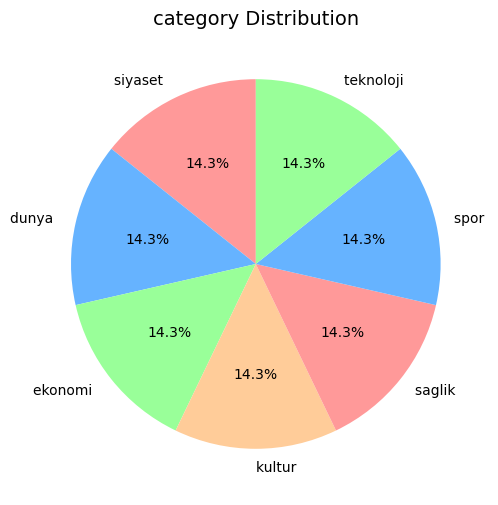

Original data class distribution:
siyaset : 700 instances (14.29%)
dunya : 700 instances (14.29%)
ekonomi : 700 instances (14.29%)
kultur : 700 instances (14.29%)
saglik : 700 instances (14.29%)
spor : 700 instances (14.29%)
teknoloji : 700 instances (14.29%)


In [13]:
from plot.plot import category_pie_chart

category_pie_chart(df_main , 'category')

# Label encoding
--------

In [15]:
label_mapping={
 'dunya ':     0,
 'ekonomi ':   1,
 'kultur ':    2,
 'saglik ':    3,
 'siyaset ':   4,
 'spor ' :     5,
 'teknoloji ': 6 
}

labels = df_main['category'].map(label_mapping)

In [16]:
print("Null value:",labels.isnull().sum()) 
print(labels.value_counts())
print('Unique labels number:',len(set(labels)))

Null value: 0
category
4    700
0    700
1    700
2    700
3    700
5    700
6    700
Name: count, dtype: int64
Unique labels number: 7


## Save the model scores

In [18]:
 results = {
        'Model': [], 'Vectorization Method': [], 
        'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []
     }

# Stopword and Lemmatizaiton 
--------

In [20]:
text_list=[]
word_list=[]#for word2vec
for text in df_main.text:
    text = text.lower()  #Upper to lower
    text = re.sub("[^abcçdefgğhıijklmnoöprsştuüvyz]"," ",text)
    text=nltk.word_tokenize(text) # splits the words that are in the sentence from each other.
    text =[word for word in text if not word in set(stopwords.words("turkish"))]
    lemma=nlp.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text] # this code finds the root of the word for a word in the sentence and change them to their root form.  
    text=" ".join(text)
    text_list.append(text) # store sentences in list

In [21]:
len(text_list)

4900

In [22]:
text_list[56]

'anayasa süreci heba edilmemeli meclis başkanı cemil çiçek yeni anayasa çalışmalarıyla ilgili görüş alışverişinde bulunmak üzere parti liderlerinden randevu istedi erdoğan la yaptığı görüşmenin ardından ntv ye konuşan çiçek umutsuz değilim süreç heba edilmemeli dedi meclis başkanı cemil çiçek yeni anayasa çalışmalarıyla ilgili parti liderlerinden randevu istedi çiçek ilk olarak akşam saatlerinde ak parti genel başkanı başbakan recep tayyip erdoğan bir araya geldi görüşmenin ardından ntv ye konuşan çiçek anayasa çalışmalarıyla ilgili süreci değerlendirdi siyaset umutsuzluk üzerine sürdürülemez diyen çiçek realiteler üzerine görüşülmesi gerektiğini vurguladı çiçek anayasa değişikliğine dair hiçbir zaman umutsuz olmadığını söyledi bugüne kadarki süreç heba edilmemeli ben kendi üzerime düşeni yapıyorum konuştu meclis başkanı liderlerle görüşmesinin ardından muhtemelen ocak çarşamba günü komisyonu toplayabileceğini düşüncelerini toplantıda değerlendireceklerini söyledi yarın saat mhp lideri

In [23]:
X_list = text_list.copy() # for LSTM ANN

# Bag of Words 
--------

In [25]:
from sklearn.feature_extraction.text import CountVectorizer #Bag of Words

max_features=500 # "number" most common(used) words in reviews
#(lowercase=True, min_df=2)

count_vectorizer=CountVectorizer(max_features=max_features) 

sparce_matrix=count_vectorizer.fit_transform(text_list).toarray()

vectorization_method = "Bag Of Words"

In [26]:
X=sparce_matrix

In [27]:
y=labels

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("x_train",X_train.shape)
print("x_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)
print("y_test",len(set(y_test)))

x_train (3920, 500)
x_test (980, 500)
y_train (3920,)
y_test (980,)
y_test 7


In [29]:
type(X_train)
print(f"X_train shape: {X_train.shape}")


y_train_label = np.asarray(y_train)  # Tek boyutlu olmalı
y_test_label = np.asarray(y_test)    #for ANN

X_train shape: (3920, 500)


<h2 style="color:hotpink;" >🚀 LightGBM</h2>
<p style="font-size:16px; color:hotpink;">
Builds decision trees sequentially, where each new tree corrects the errors of the previous ones. It focuses on data grouping (histogram-based) to speed up processing.
</p>

<table style="width:50%; border:1px solid black; border-collapse:collapse; text-align:center;">
  <tr style="background-color:#f2f2f2;">
    <th style="border:1px solid black; padding:10px;">Feature</th>
    <th style="border:1px solid black; padding:10px;">Memory Usage</th>
    <th style="border:1px solid black; padding:10px;">Speed</th>
    <th style="border:1px solid black; padding:10px;">Accuracy</th>
    <th style="border:1px solid black; padding:10px;">Best Use Case</th>
  </tr>
  <tr>
    <td style="border:1px solid black; padding:10px;"><strong>LightGBM</strong></td>
    <td style="border:1px solid black; padding:10px;">Low-Medium</td>
    <td style="border:1px solid black; padding:10px;">Very Fast</td>
    <td style="border:1px solid black; padding:10px;">High</td>
    <td style="border:1px solid black; padding:10px;">Large datasets, categorical data</td>
  </tr>
</table>


In [31]:
lgbm_model=LGBMClassifier(n_estimators=10)

In [32]:
lgbm_model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3729
[LightGBM] [Info] Number of data points in the train set: 3920, number of used features: 500
[LightGBM] [Info] Start training from score -1.929966
[LightGBM] [Info] Start training from score -1.949488
[LightGBM] [Info] Start training from score -1.944126
[LightGBM] [Info] Start training from score -1.914273
[LightGBM] [Info] Start training from score -1.978581
[LightGBM] [Info] Start training from score -1.958489
[LightGBM] [Info] Start training from score -1.947697


LGBMClassifier(n_estimators=10)

In [33]:
y_pred=lgbm_model.predict(X_test)

In [34]:
from eval.model_score import model_scoring
model_scoring(y_test,y_pred,results,'LightGBM',vectorization_method)

LightGBM | Bag Of Words:
F1 Score 0.7798 | Accuracy:0.7816 | Precision:0.7803 | Recall:0.7816  
Results saved to eval/score.csv


<Axes: >

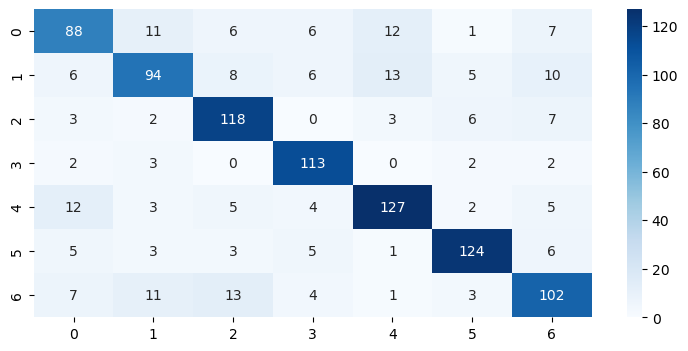

In [35]:
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d') #viridis, coolwarm ,Blues ,YlGnBu

In [36]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.72      0.67      0.69       131
           1       0.74      0.66      0.70       142
           2       0.77      0.85      0.81       139
           3       0.82      0.93      0.87       122
           4       0.81      0.80      0.81       158
           5       0.87      0.84      0.86       147
           6       0.73      0.72      0.73       141

    accuracy                           0.78       980
   macro avg       0.78      0.78      0.78       980
weighted avg       0.78      0.78      0.78       980



y_test unique value :[0 1 2 3 4 5 6]


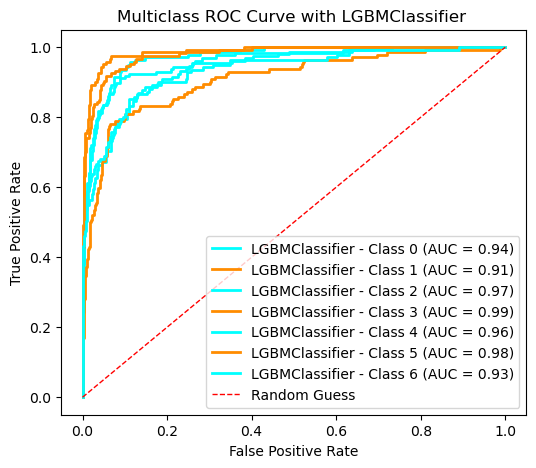

In [37]:
from plot.roc import plot_multi_roc

plot_multi_roc(X_test, y_test,lgbm_model)

<h2 style="color:blue;" >🚀 Xgbm</h2>
<p style="font-size:16px; color:clay;">
Similar to LightGBM, it uses decision trees to make predictions, but with more advanced optimization techniques. It is slightly slower but highly configurable.
</p>

<table style="width:50%; border:1px solid black; border-collapse:collapse; text-align:center;">
  <tr style="background-color:#f2f2f2;">
    <th style="border:1px solid black; padding:10px;">Feature</th>
    <th style="border:1px solid black; padding:10px;">Memory Usage</th>
    <th style="border:1px solid black; padding:10px;">Speed</th>
    <th style="border:1px solid black; padding:10px;">Accuracy</th>
      <th style="border:1px solid black; padding:10px;">Best Use Case</th>
  </tr>
  <tr>
    <td style="border:1px solid black; padding:10px;"><strong>Xgbm</strong></td>
    <td style="border:1px solid black; padding:10px;">Medium</td>
    <td style="border:1px solid black; padding:10px;">Medium</td>
    <td style="border:1px solid black; padding:10px;">High</td>
      <td style="border:1px solid black; padding:10px;">Balanced datasets, complex problems</td>
  </tr>
</table>

In [39]:
import xgboost as xgb
from xgboost import XGBClassifier

xgbm = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
print(f"Tree Method: {xgbm.get_params()['tree_method']}")

Tree Method: gpu_hist


In [40]:
xgbm.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [41]:
y_pred = xgbm.predict(X_test)

In [42]:
from eval.model_score import model_scoring
model_scoring(y_test,y_pred,results,'Xgbm',vectorization_method)

Xgbm | Bag Of Words:
F1 Score 0.8336 | Accuracy:0.8337 | Precision:0.8344 | Recall:0.8337  
Results saved to eval/score.csv


<Axes: >

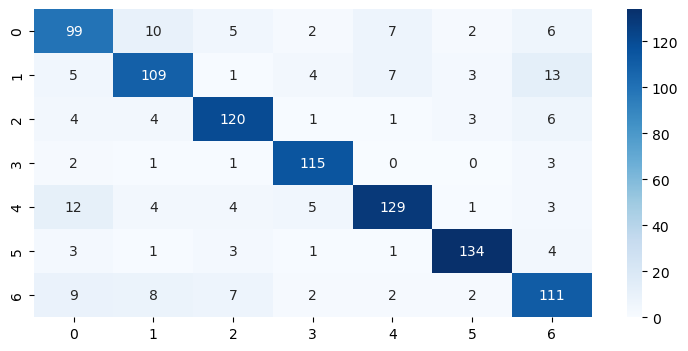

In [43]:
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [44]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       131
           1       0.80      0.77      0.78       142
           2       0.85      0.86      0.86       139
           3       0.88      0.94      0.91       122
           4       0.88      0.82      0.85       158
           5       0.92      0.91      0.92       147
           6       0.76      0.79      0.77       141

    accuracy                           0.83       980
   macro avg       0.83      0.83      0.83       980
weighted avg       0.83      0.83      0.83       980



y_test unique value :[0 1 2 3 4 5 6]


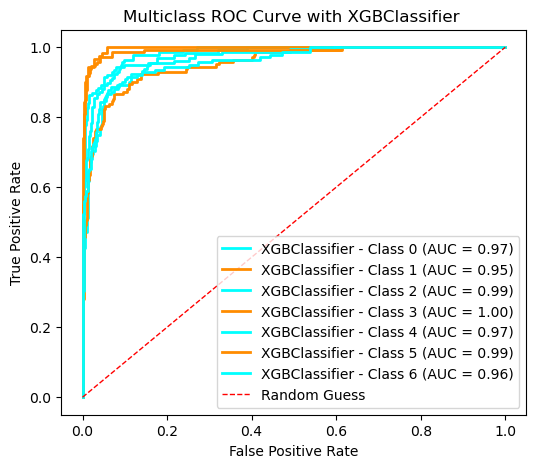

In [45]:
from plot.roc import plot_multi_roc

plot_multi_roc(X_test, y_test,xgbm)

<h2 style="color:blue;" >🚀 Naive Bayes </h2>
<p style="font-size:16px; color:clay;">
Classifies data based on statistical probabilities. It assumes that features are independent of each other, which simplifies the computation..
</p>

<table style="width:50%; border:1px solid black; border-collapse:collapse; text-align:center;">
  <tr style="background-color:#f2f2f2;">
    <th style="border:1px solid black; padding:10px;">Feature</th>
    <th style="border:1px solid black; padding:10px;">Memory Usage</th>
    <th style="border:1px solid black; padding:10px;">Speed</th>
    <th style="border:1px solid black; padding:10px;">Accuracy</th>
      <th style="border:1px solid black; padding:10px;">Best Use Case</th>
  </tr>
  <tr>
    <td style="border:1px solid black; padding:10px;"><strong>Naive Bayes</strong></td>
    <td style="border:1px solid black; padding:10px;">Very Low</td>
    <td style="border:1px solid black; padding:10px;">Very Fast</td>
    <td style="border:1px solid black; padding:10px;">Moderate</td>
       <td style="border:1px solid black; padding:10px;">Text classification, simple problems</td>
  </tr>
</table>

In [47]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()

In [48]:
naive_bayes.fit(X_train, y_train)

GaussianNB()

In [49]:
y_pred = naive_bayes.predict(X_test)

In [50]:
from eval.model_score import model_scoring
model_scoring(y_test,y_pred,results,'Naive Bayes',vectorization_method)

Naive Bayes | Bag Of Words:
F1 Score 0.7060 | Accuracy:0.7122 | Precision:0.7285 | Recall:0.7122  
Results saved to eval/score.csv


<Axes: >

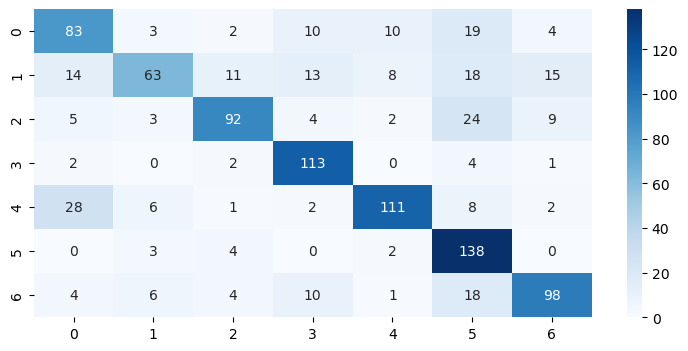

In [51]:
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [52]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.61      0.63      0.62       131
           1       0.75      0.44      0.56       142
           2       0.79      0.66      0.72       139
           3       0.74      0.93      0.82       122
           4       0.83      0.70      0.76       158
           5       0.60      0.94      0.73       147
           6       0.76      0.70      0.73       141

    accuracy                           0.71       980
   macro avg       0.73      0.71      0.71       980
weighted avg       0.73      0.71      0.71       980



y_test unique value :[0 1 2 3 4 5 6]


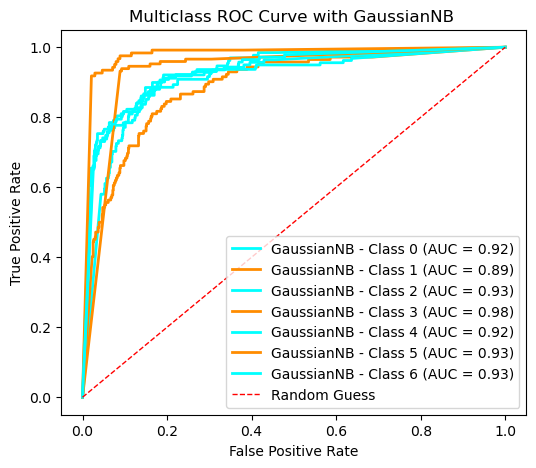

In [53]:
from plot.roc import plot_multi_roc

plot_multi_roc(X_test, y_test,naive_bayes)

<h2 style="color:blue;" >🚀 SVM RBF </h2>
<p style="font-size:16px; color:clay;">
 Finds the best boundary (hyperplane) that separates data into classes. The RBF kernel allows it to create complex, non-linear decision boundaries for better accuracy.
</p>

<table style="width:50%; border:1px solid black; border-collapse:collapse; text-align:center;">
  <tr style="background-color:#f2f2f2;">
    <th style="border:1px solid black; padding:10px;">Feature</th>
    <th style="border:1px solid black; padding:10px;">Memory Usage</th>
    <th style="border:1px solid black; padding:10px;">Speed</th>
    <th style="border:1px solid black; padding:10px;">Accuracy</th>
      <th style="border:1px solid black; padding:10px;">Best Use Case</th>
  </tr>
  <tr>
    <td style="border:1px solid black; padding:10px;"><strong>SVM RBF </strong></td>
    <td style="border:1px solid black; padding:10px;">High</td>
    <td style="border:1px solid black; padding:10px;">Slow</td>
    <td style="border:1px solid black; padding:10px;">Very High</td>
       <td style="border:1px solid black; padding:10px;">Small/medium datasets, complex classes</td>
  </tr>
</table>

In [55]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', random_state=42,probability=True)

In [56]:
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [57]:
y_pred= svm_model.predict(X_test)

In [58]:
from eval.model_score import model_scoring
model_scoring(y_test,y_pred,results,'SVM-RBF',vectorization_method)

SVM-RBF | Bag Of Words:
F1 Score 0.8077 | Accuracy:0.8082 | Precision:0.8088 | Recall:0.8082  
Results saved to eval/score.csv


<Axes: >

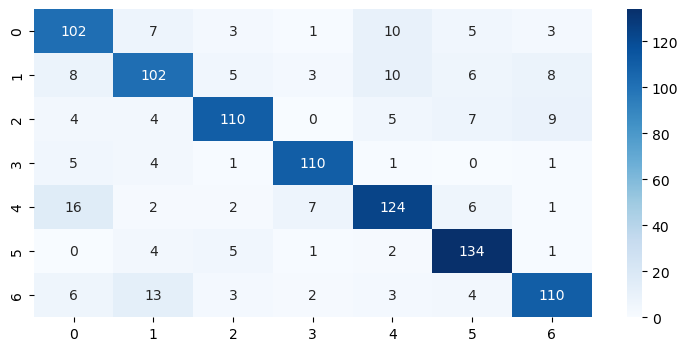

In [59]:
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [60]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       131
           1       0.75      0.72      0.73       142
           2       0.85      0.79      0.82       139
           3       0.89      0.90      0.89       122
           4       0.80      0.78      0.79       158
           5       0.83      0.91      0.87       147
           6       0.83      0.78      0.80       141

    accuracy                           0.81       980
   macro avg       0.81      0.81      0.81       980
weighted avg       0.81      0.81      0.81       980



y_test unique value :[0 1 2 3 4 5 6]


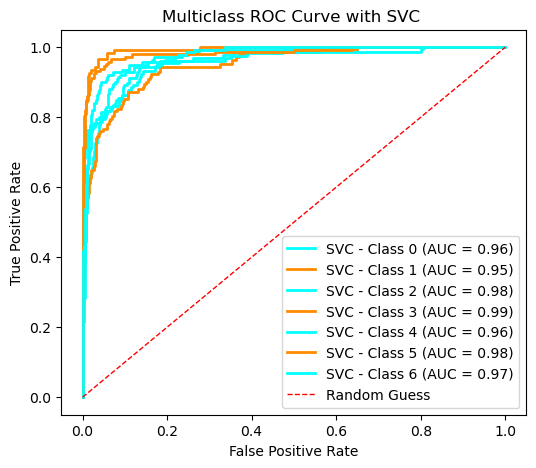

In [61]:
from plot.roc import plot_multi_roc

plot_multi_roc(X_test, y_test,svm_model)

<h2 style="color:olive;" >🚀 SimpleANN</h2>


In [63]:
# Hyperparameters for the simple ANN

input_dim = X_train.shape[1]; # 500
hidden_dim = 32
output_dim = len(set(labels))  # class numbers

LEARNING_RATE=0.001

num_epochs=50
BATCH_SIZE= 4

In [64]:
from nn_arch.simple_ann import SimpleANN
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

for i in range(torch.cuda.device_count()):
    print(f"device {i}: {torch.cuda.get_device_name(i)}\n")


simple_ann = SimpleANN(input_dim, hidden_dim, output_dim).to(device)
print(simple_ann)

#-----------

criterion = torch.nn.CrossEntropyLoss()  # loss func
optimizer = torch.optim.Adam(simple_ann.parameters(), lr=LEARNING_RATE)  # optimization alg

device: cuda
device 0: NVIDIA GeForce RTX 4060 Laptop GPU

SimpleANN(
  (fc1): Linear(in_features=500, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)


In [65]:
from torch.utils.data import DataLoader, TensorDataset


# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_label, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_label, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)



In [66]:
from nn_arch.nn_trainer import model_training

history, test, true = model_training(vectorization_method,
               simple_ann, criterion, optimizer,
               train_loader, val_loader,
               num_epochs = num_epochs)

Device: cuda
Epoch 1/50, Loss: 1.5591, Accuracy: 0.6607, Val Loss: 1.3813, Val Accuracy: 0.8153
Epoch 2/50, Loss: 1.3348, Accuracy: 0.8469, Val Loss: 1.3604, Val Accuracy: 0.8143
Epoch 3/50, Loss: 1.2950, Accuracy: 0.8821, Val Loss: 1.3372, Val Accuracy: 0.8347
Epoch 4/50, Loss: 1.2771, Accuracy: 0.8959, Val Loss: 1.3379, Val Accuracy: 0.8245
Epoch 5/50, Loss: 1.2616, Accuracy: 0.9074, Val Loss: 1.3374, Val Accuracy: 0.8306
Epoch 6/50, Loss: 1.2537, Accuracy: 0.9163, Val Loss: 1.3375, Val Accuracy: 0.8296
Epoch 7/50, Loss: 1.2478, Accuracy: 0.9212, Val Loss: 1.3221, Val Accuracy: 0.8480
Epoch 8/50, Loss: 1.2453, Accuracy: 0.9235, Val Loss: 1.3423, Val Accuracy: 0.8214
Epoch 9/50, Loss: 1.2427, Accuracy: 0.9247, Val Loss: 1.3394, Val Accuracy: 0.8235
Epoch 10/50, Loss: 1.2416, Accuracy: 0.9263, Val Loss: 1.3301, Val Accuracy: 0.8367
Epoch 11/50, Loss: 1.2396, Accuracy: 0.9278, Val Loss: 1.3308, Val Accuracy: 0.8327
Epoch 12/50, Loss: 1.2331, Accuracy: 0.9319, Val Loss: 1.3311, Val Accur

In [67]:
model_scoring(test, true ,results,simple_ann.__class__.__name__,vectorization_method)

SimpleANN | Bag Of Words:
F1 Score 0.8360 | Accuracy:0.8357 | Precision:0.8382 | Recall:0.8357  
Results saved to eval/score.csv


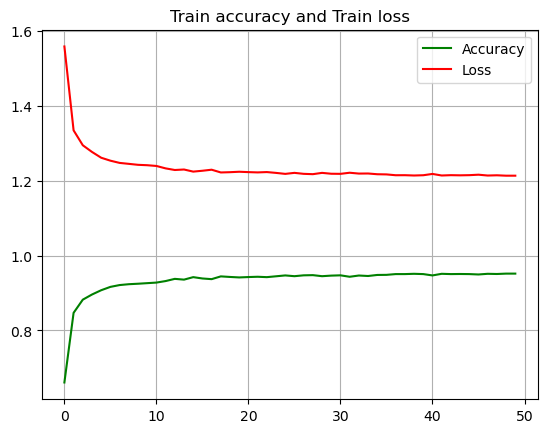

In [68]:
plt.plot(history["accuracy"],color="green")
plt.plot(history["loss"],color="red")
plt.title("Train accuracy and Train loss")
plt.legend(["Accuracy","Loss"])
plt.grid()

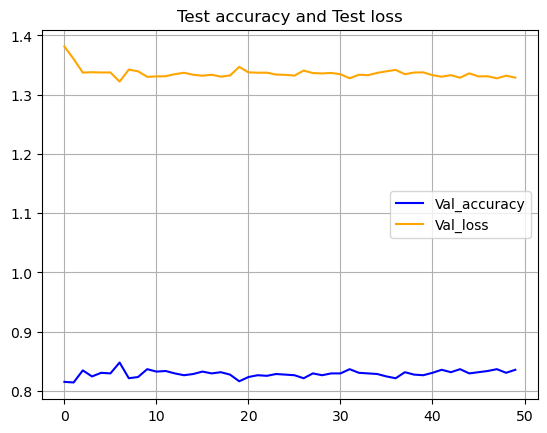

In [69]:
plt.plot(history["val_accuracy"],color="blue")
plt.plot(history["val_loss"],color="orange")
plt.title("Test accuracy and Test loss")
plt.legend(["Val_accuracy","Val_loss"])
plt.grid()


<Axes: >

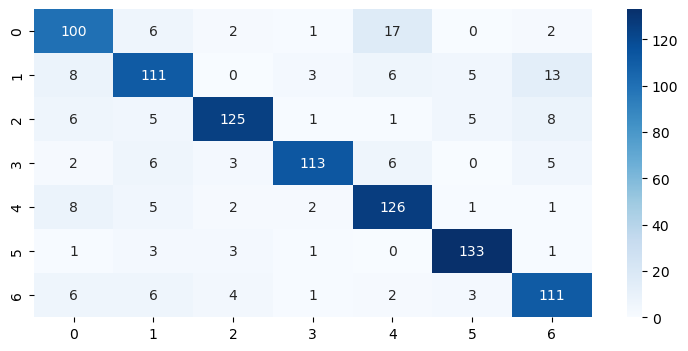

In [70]:
cm=confusion_matrix(test,true)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [71]:
print(classification_report(test, true)) 

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       128
           1       0.78      0.76      0.77       146
           2       0.90      0.83      0.86       151
           3       0.93      0.84      0.88       135
           4       0.80      0.87      0.83       145
           5       0.90      0.94      0.92       142
           6       0.79      0.83      0.81       133

    accuracy                           0.84       980
   macro avg       0.84      0.84      0.84       980
weighted avg       0.84      0.84      0.84       980



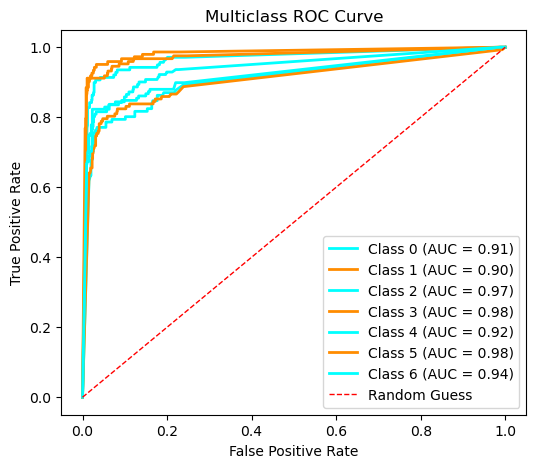

In [72]:
from plot.roc_NN import plot_multi_roc_NN

plot_multi_roc_NN(X_test, y_test,simple_ann,batch_size=BATCH_SIZE)

# TF_IDF
--------

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define TF-IDF parameters
max_features = 500  # Limit to the top 500 most frequent words
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)

# Transform text data to TF-IDF matrix
tfidf_sparce_matrix = tfidf_vectorizer.fit_transform(text_list).toarray()

vectorization_method = "TF_IDF"

In [75]:
X=tfidf_sparce_matrix

In [76]:
y=labels

In [77]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("x_train",X_train.shape)
print("x_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)
print("y_test",len(set(y_test)))

x_train (3920, 500)
x_test (980, 500)
y_train (3920,)
y_test (980,)
y_test 7


In [78]:
type(X_train)
print(f"X_train shape: {X_train.shape}")


y_train_label = np.asarray(y_train)  # Tek boyutlu olmalı
y_test_label = np.asarray(y_test)    #for ANN

X_train shape: (3920, 500)


<h2 style="color:hotpink;" >🚀 LightGBM</h2>
<p style="font-size:16px; color:hotpink;">
Builds decision trees sequentially, where each new tree corrects the errors of the previous ones. It focuses on data grouping (histogram-based) to speed up processing.
</p>

<table style="width:50%; border:1px solid black; border-collapse:collapse; text-align:center;">
  <tr style="background-color:#f2f2f2;">
    <th style="border:1px solid black; padding:10px;">Feature</th>
    <th style="border:1px solid black; padding:10px;">Memory Usage</th>
    <th style="border:1px solid black; padding:10px;">Speed</th>
    <th style="border:1px solid black; padding:10px;">Accuracy</th>
    <th style="border:1px solid black; padding:10px;">Best Use Case</th>
  </tr>
  <tr>
    <td style="border:1px solid black; padding:10px;"><strong>LightGBM</strong></td>
    <td style="border:1px solid black; padding:10px;">Low-Medium</td>
    <td style="border:1px solid black; padding:10px;">Very Fast</td>
    <td style="border:1px solid black; padding:10px;">High</td>
    <td style="border:1px solid black; padding:10px;">Large datasets, categorical data</td>
  </tr>
</table>


In [80]:
lgbm_model=LGBMClassifier(n_estimators=10)

In [81]:
lgbm_model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53337
[LightGBM] [Info] Number of data points in the train set: 3920, number of used features: 500
[LightGBM] [Info] Start training from score -1.929966
[LightGBM] [Info] Start training from score -1.949488
[LightGBM] [Info] Start training from score -1.944126
[LightGBM] [Info] Start training from score -1.914273
[LightGBM] [Info] Start training from score -1.978581
[LightGBM] [Info] Start training from score -1.958489
[LightGBM] [Info] Start training from score -1.947697


LGBMClassifier(n_estimators=10)

In [82]:
y_pred=lgbm_model.predict(X_test)

In [83]:
from eval.model_score import model_scoring
model_scoring(y_test,y_pred,results,'LightGBM',vectorization_method)

LightGBM | TF_IDF:
F1 Score 0.7759 | Accuracy:0.7776 | Precision:0.7768 | Recall:0.7776  
Results saved to eval/score.csv


<Axes: >

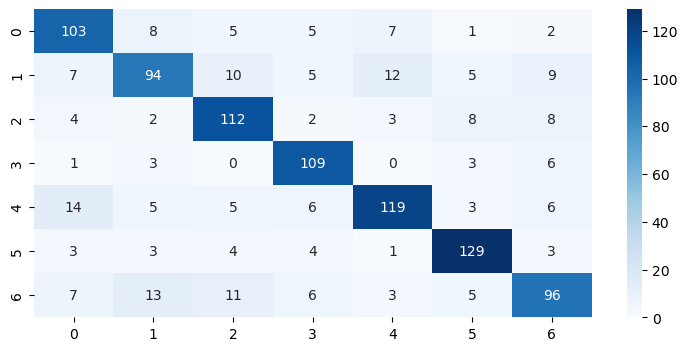

In [84]:
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [85]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       131
           1       0.73      0.66      0.70       142
           2       0.76      0.81      0.78       139
           3       0.80      0.89      0.84       122
           4       0.82      0.75      0.79       158
           5       0.84      0.88      0.86       147
           6       0.74      0.68      0.71       141

    accuracy                           0.78       980
   macro avg       0.78      0.78      0.78       980
weighted avg       0.78      0.78      0.78       980



y_test unique value :[0 1 2 3 4 5 6]


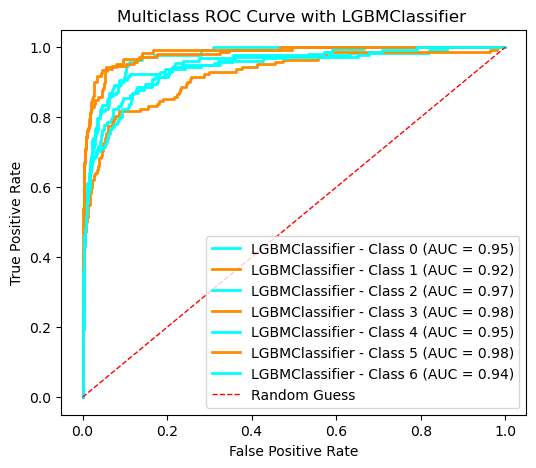

In [86]:
from plot.roc import plot_multi_roc

plot_multi_roc(X_test, y_test,lgbm_model)

<h2 style="color:blue;" >🚀 Xgbm</h2>
<p style="font-size:16px; color:clay;">
Similar to LightGBM, it uses decision trees to make predictions, but with more advanced optimization techniques. It is slightly slower but highly configurable.
</p>

<table style="width:50%; border:1px solid black; border-collapse:collapse; text-align:center;">
  <tr style="background-color:#f2f2f2;">
    <th style="border:1px solid black; padding:10px;">Feature</th>
    <th style="border:1px solid black; padding:10px;">Memory Usage</th>
    <th style="border:1px solid black; padding:10px;">Speed</th>
    <th style="border:1px solid black; padding:10px;">Accuracy</th>
      <th style="border:1px solid black; padding:10px;">Best Use Case</th>
  </tr>
  <tr>
    <td style="border:1px solid black; padding:10px;"><strong>Xgbm</strong></td>
    <td style="border:1px solid black; padding:10px;">Medium</td>
    <td style="border:1px solid black; padding:10px;">Medium</td>
    <td style="border:1px solid black; padding:10px;">High</td>
      <td style="border:1px solid black; padding:10px;">Balanced datasets, complex problems</td>
  </tr>
</table>

In [88]:
import xgboost as xgb
from xgboost import XGBClassifier

xgbm = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
print(f"Tree Method: {xgbm.get_params()['tree_method']}")

Tree Method: gpu_hist


In [89]:
xgbm.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [90]:
y_pred = xgbm.predict(X_test)

In [91]:
from eval.model_score import model_scoring
model_scoring(y_test,y_pred,results,'Xgbm',vectorization_method)

Xgbm | TF_IDF:
F1 Score 0.8257 | Accuracy:0.8255 | Precision:0.8273 | Recall:0.8255  
Results saved to eval/score.csv


<Axes: >

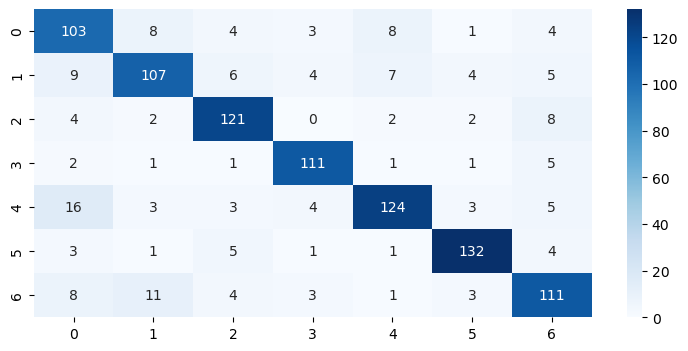

In [92]:
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [93]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       131
           1       0.80      0.75      0.78       142
           2       0.84      0.87      0.86       139
           3       0.88      0.91      0.90       122
           4       0.86      0.78      0.82       158
           5       0.90      0.90      0.90       147
           6       0.78      0.79      0.78       141

    accuracy                           0.83       980
   macro avg       0.83      0.83      0.83       980
weighted avg       0.83      0.83      0.83       980



y_test unique value :[0 1 2 3 4 5 6]


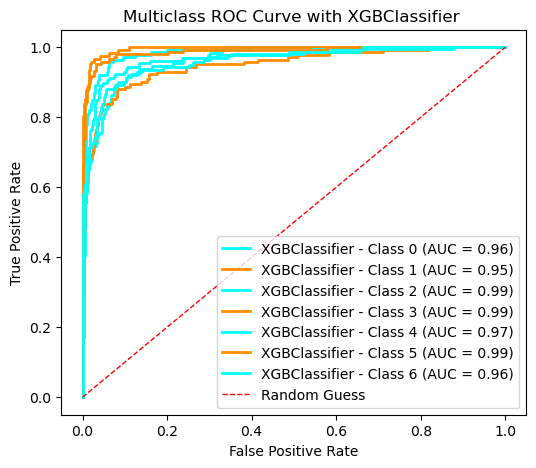

In [94]:
from plot.roc import plot_multi_roc

plot_multi_roc(X_test, y_test,xgbm)

<h2 style="color:blue;" >🚀 Naive Bayes </h2>
<p style="font-size:16px; color:clay;">
Classifies data based on statistical probabilities. It assumes that features are independent of each other, which simplifies the computation..
</p>

<table style="width:50%; border:1px solid black; border-collapse:collapse; text-align:center;">
  <tr style="background-color:#f2f2f2;">
    <th style="border:1px solid black; padding:10px;">Feature</th>
    <th style="border:1px solid black; padding:10px;">Memory Usage</th>
    <th style="border:1px solid black; padding:10px;">Speed</th>
    <th style="border:1px solid black; padding:10px;">Accuracy</th>
      <th style="border:1px solid black; padding:10px;">Best Use Case</th>
  </tr>
  <tr>
    <td style="border:1px solid black; padding:10px;"><strong>Naive Bayes</strong></td>
    <td style="border:1px solid black; padding:10px;">Very Low</td>
    <td style="border:1px solid black; padding:10px;">Very Fast</td>
    <td style="border:1px solid black; padding:10px;">Moderate</td>
       <td style="border:1px solid black; padding:10px;">Text classification, simple problems</td>
  </tr>
</table>

In [96]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()

In [97]:
naive_bayes.fit(X_train, y_train)

GaussianNB()

In [98]:
y_pred = naive_bayes.predict(X_test)

In [99]:
from eval.model_score import model_scoring
model_scoring(y_test,y_pred,results,'Naive Bayes',vectorization_method)

Naive Bayes | TF_IDF:
F1 Score 0.7690 | Accuracy:0.7735 | Precision:0.7763 | Recall:0.7735  
Results saved to eval/score.csv


<Axes: >

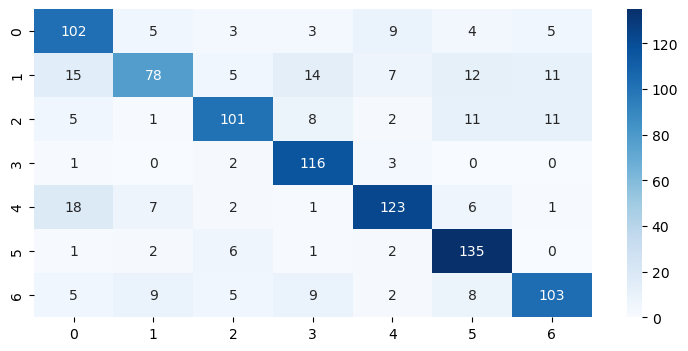

In [100]:
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [101]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       131
           1       0.76      0.55      0.64       142
           2       0.81      0.73      0.77       139
           3       0.76      0.95      0.85       122
           4       0.83      0.78      0.80       158
           5       0.77      0.92      0.84       147
           6       0.79      0.73      0.76       141

    accuracy                           0.77       980
   macro avg       0.77      0.78      0.77       980
weighted avg       0.78      0.77      0.77       980



y_test unique value :[0 1 2 3 4 5 6]


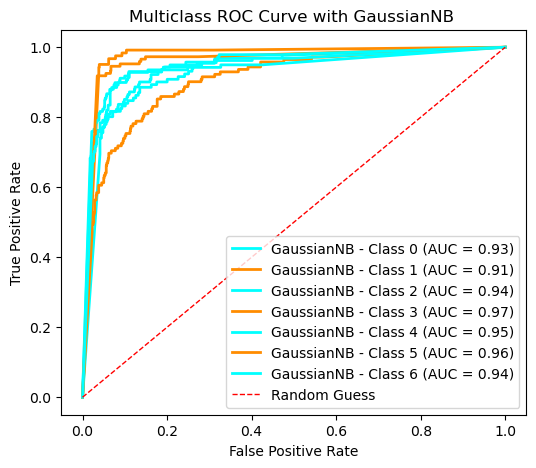

In [102]:
from plot.roc import plot_multi_roc

plot_multi_roc(X_test, y_test,naive_bayes)

<h2 style="color:blue;" >🚀 SVM RBF </h2>
<p style="font-size:16px; color:clay;">
 Finds the best boundary (hyperplane) that separates data into classes. The RBF kernel allows it to create complex, non-linear decision boundaries for better accuracy.
</p>

<table style="width:50%; border:1px solid black; border-collapse:collapse; text-align:center;">
  <tr style="background-color:#f2f2f2;">
    <th style="border:1px solid black; padding:10px;">Feature</th>
    <th style="border:1px solid black; padding:10px;">Memory Usage</th>
    <th style="border:1px solid black; padding:10px;">Speed</th>
    <th style="border:1px solid black; padding:10px;">Accuracy</th>
      <th style="border:1px solid black; padding:10px;">Best Use Case</th>
  </tr>
  <tr>
    <td style="border:1px solid black; padding:10px;"><strong>SVM RBF </strong></td>
    <td style="border:1px solid black; padding:10px;">High</td>
    <td style="border:1px solid black; padding:10px;">Slow</td>
    <td style="border:1px solid black; padding:10px;">Very High</td>
       <td style="border:1px solid black; padding:10px;">Small/medium datasets, complex classes</td>
  </tr>
</table>

In [104]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', random_state=42,probability=True)

In [105]:
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [106]:
y_pred= svm_model.predict(X_test)

In [107]:
from eval.model_score import model_scoring
model_scoring(y_test,y_pred,results,'SVM-RBF',vectorization_method)

SVM-RBF | TF_IDF:
F1 Score 0.8564 | Accuracy:0.8561 | Precision:0.8570 | Recall:0.8561  
Results saved to eval/score.csv


<Axes: >

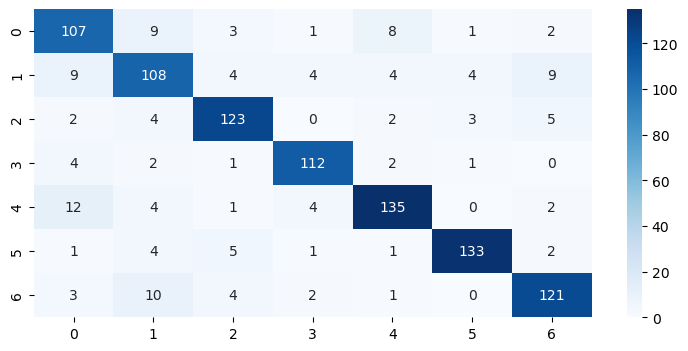

In [108]:
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [109]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       131
           1       0.77      0.76      0.76       142
           2       0.87      0.88      0.88       139
           3       0.90      0.92      0.91       122
           4       0.88      0.85      0.87       158
           5       0.94      0.90      0.92       147
           6       0.86      0.86      0.86       141

    accuracy                           0.86       980
   macro avg       0.86      0.86      0.86       980
weighted avg       0.86      0.86      0.86       980



y_test unique value :[0 1 2 3 4 5 6]


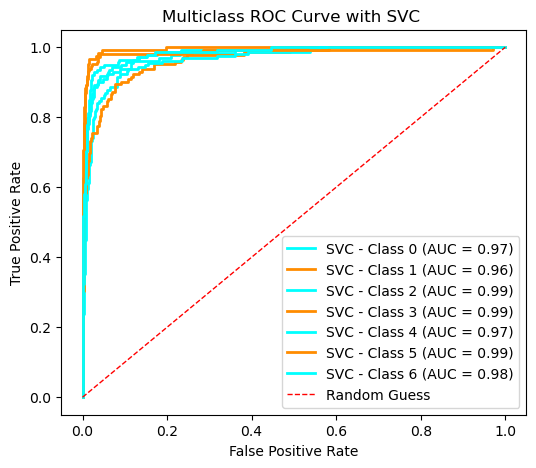

In [110]:
from plot.roc import plot_multi_roc

plot_multi_roc(X_test, y_test,svm_model)

<h2 style="color:olive;" >🚀 SimpleANN</h2>


In [112]:
# Hyperparameters for the simple ANN

input_dim = X_train.shape[1]; # 500
hidden_dim = 32
output_dim = len(set(labels))  # class numbers

LEARNING_RATE=0.001

num_epochs=50
BATCH_SIZE= 4

In [113]:
from nn_arch.simple_ann import SimpleANN
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

for i in range(torch.cuda.device_count()):
    print(f"device {i}: {torch.cuda.get_device_name(i)}\n")


simple_ann = SimpleANN(input_dim, hidden_dim, output_dim).to(device)
print(simple_ann)

#-----------

criterion = torch.nn.CrossEntropyLoss()  # loss func
optimizer = torch.optim.Adam(simple_ann.parameters(), lr=LEARNING_RATE)  # optimization alg

device: cuda
device 0: NVIDIA GeForce RTX 4060 Laptop GPU

SimpleANN(
  (fc1): Linear(in_features=500, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)


In [114]:
from torch.utils.data import DataLoader, TensorDataset


# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_label, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_label, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)



In [115]:
from nn_arch.nn_trainer import model_training

history, test, true = model_training(vectorization_method,
               simple_ann, criterion, optimizer,
               train_loader, val_loader,
               num_epochs = num_epochs)

Device: cuda
Epoch 1/50, Loss: 1.6972, Accuracy: 0.5426, Val Loss: 1.4377, Val Accuracy: 0.7888
Epoch 2/50, Loss: 1.3786, Accuracy: 0.8207, Val Loss: 1.3661, Val Accuracy: 0.8245
Epoch 3/50, Loss: 1.3214, Accuracy: 0.8622, Val Loss: 1.3492, Val Accuracy: 0.8276
Epoch 4/50, Loss: 1.2918, Accuracy: 0.8883, Val Loss: 1.3478, Val Accuracy: 0.8245
Epoch 5/50, Loss: 1.2735, Accuracy: 0.9054, Val Loss: 1.3418, Val Accuracy: 0.8286
Epoch 6/50, Loss: 1.2608, Accuracy: 0.9148, Val Loss: 1.3362, Val Accuracy: 0.8327
Epoch 7/50, Loss: 1.2487, Accuracy: 0.9250, Val Loss: 1.3361, Val Accuracy: 0.8316
Epoch 8/50, Loss: 1.2413, Accuracy: 0.9304, Val Loss: 1.3373, Val Accuracy: 0.8296
Epoch 9/50, Loss: 1.2358, Accuracy: 0.9339, Val Loss: 1.3319, Val Accuracy: 0.8347
Epoch 10/50, Loss: 1.2317, Accuracy: 0.9367, Val Loss: 1.3329, Val Accuracy: 0.8306
Epoch 11/50, Loss: 1.2287, Accuracy: 0.9388, Val Loss: 1.3425, Val Accuracy: 0.8235
Epoch 12/50, Loss: 1.2284, Accuracy: 0.9395, Val Loss: 1.3333, Val Accur

In [116]:
model_scoring(test, true ,results,simple_ann.__class__.__name__,vectorization_method)

SimpleANN | TF_IDF:
F1 Score 0.8306 | Accuracy:0.8296 | Precision:0.8327 | Recall:0.8296  
Results saved to eval/score.csv


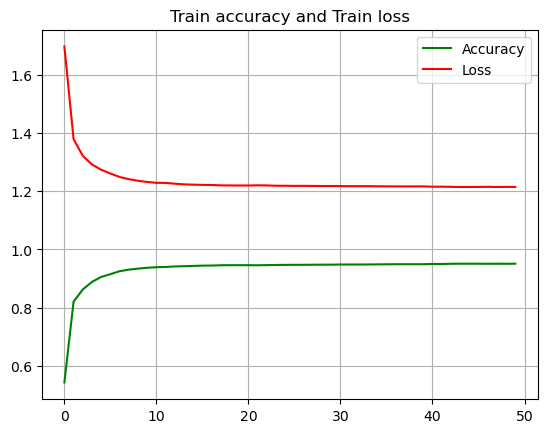

In [117]:
plt.plot(history["accuracy"],color="green")
plt.plot(history["loss"],color="red")
plt.title("Train accuracy and Train loss")
plt.legend(["Accuracy","Loss"])
plt.grid()

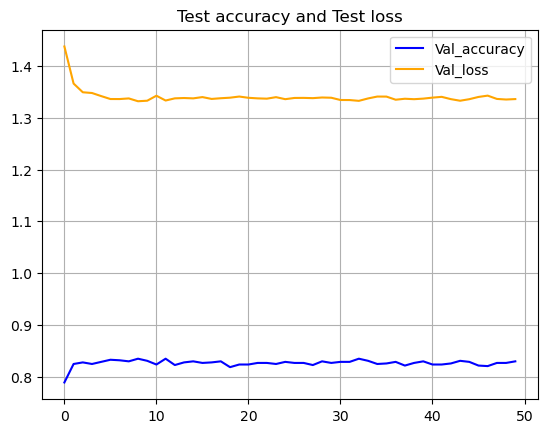

In [118]:
plt.plot(history["val_accuracy"],color="blue")
plt.plot(history["val_loss"],color="orange")
plt.title("Test accuracy and Test loss")
plt.legend(["Val_accuracy","Val_loss"])
plt.grid()


<Axes: >

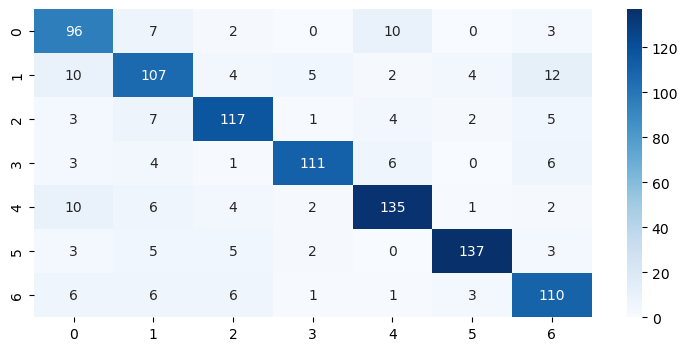

In [119]:
cm=confusion_matrix(test,true)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [120]:
print(classification_report(test, true)) 

              precision    recall  f1-score   support

           0       0.73      0.81      0.77       118
           1       0.75      0.74      0.75       144
           2       0.84      0.84      0.84       139
           3       0.91      0.85      0.88       131
           4       0.85      0.84      0.85       160
           5       0.93      0.88      0.91       155
           6       0.78      0.83      0.80       133

    accuracy                           0.83       980
   macro avg       0.83      0.83      0.83       980
weighted avg       0.83      0.83      0.83       980



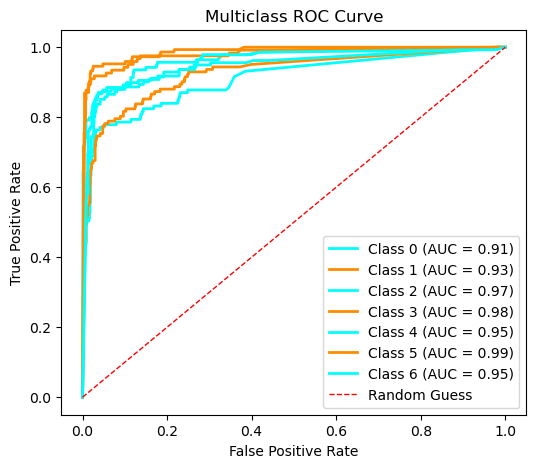

In [121]:
from plot.roc_NN import plot_multi_roc_NN

plot_multi_roc_NN(X_test, y_test,simple_ann,batch_size=BATCH_SIZE)

# Word2Vec
--------

In [123]:
tokens = []
for text in text_list:
    text=nltk.word_tokenize(text)
    tokens.append(text)

In [124]:
print(tokens[56])

['anayasa', 'süreci', 'heba', 'edilmemeli', 'meclis', 'başkanı', 'cemil', 'çiçek', 'yeni', 'anayasa', 'çalışmalarıyla', 'ilgili', 'görüş', 'alışverişinde', 'bulunmak', 'üzere', 'parti', 'liderlerinden', 'randevu', 'istedi', 'erdoğan', 'la', 'yaptığı', 'görüşmenin', 'ardından', 'ntv', 'ye', 'konuşan', 'çiçek', 'umutsuz', 'değilim', 'süreç', 'heba', 'edilmemeli', 'dedi', 'meclis', 'başkanı', 'cemil', 'çiçek', 'yeni', 'anayasa', 'çalışmalarıyla', 'ilgili', 'parti', 'liderlerinden', 'randevu', 'istedi', 'çiçek', 'ilk', 'olarak', 'akşam', 'saatlerinde', 'ak', 'parti', 'genel', 'başkanı', 'başbakan', 'recep', 'tayyip', 'erdoğan', 'bir', 'araya', 'geldi', 'görüşmenin', 'ardından', 'ntv', 'ye', 'konuşan', 'çiçek', 'anayasa', 'çalışmalarıyla', 'ilgili', 'süreci', 'değerlendirdi', 'siyaset', 'umutsuzluk', 'üzerine', 'sürdürülemez', 'diyen', 'çiçek', 'realiteler', 'üzerine', 'görüşülmesi', 'gerektiğini', 'vurguladı', 'çiçek', 'anayasa', 'değişikliğine', 'dair', 'hiçbir', 'zaman', 'umutsuz', 'olma

In [125]:
from gensim.models import Word2Vec
import numpy as np

# Parameters
max_features = 500  # Limit the number of features to the top 500 most frequent words
window_size = 5      # Context window size for Word2Vec
min_word_count = 1   # Minimum word frequency for inclusion in the vocabulary
num_workers = 8      # Number of worker threads for parallel processing

# Train a Word2Vec model
word2vec_model = Word2Vec(
    sentences=tokens,  # Input list of tokenized sentences
    vector_size=max_features,
    window=window_size,
    min_count=min_word_count,
    workers=num_workers
)

# Save the trained Word2Vec model
import os
file_path = os.path.join('models\Word2vec', 'word2vec_007.model')
os.makedirs('models\Word2vec', exist_ok=True)
word2vec_model.save(file_path)

# Convert sentences into vectors
sentence_vectors = []

for sentence in tokens:
    # Retrieve word vectors for words present in the Word2Vec vocabulary
    word_vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    
    if word_vectors:  # If the sentence contains valid word vectors
        sentence_vector = np.mean(word_vectors, axis=0)  # Compute the mean vector for the sentence
    else:  # If the sentence is empty or contains no known words
        sentence_vector = np.zeros(word2vec_model.vector_size)  # Assign a zero vector

    sentence_vectors.append(sentence_vector)

# Convert the list of sentence vectors to a NumPy array
sentence_vectors = np.array(sentence_vectors)



In [126]:
# Print information for verification
print("Shape of sentence vectors:", sentence_vectors.shape)

vectorization_method = "Word2Vec"

Shape of sentence vectors: (4900, 500)


In [127]:
X=sentence_vectors

In [128]:
y=labels

In [129]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("x_train",X_train.shape)
print("x_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)
print("y_test",len(set(y_test)))

x_train (3920, 500)
x_test (980, 500)
y_train (3920,)
y_test (980,)
y_test 7


In [130]:
type(X_train)
print(f"X_train shape: {X_train.shape}")


y_train_label = np.asarray(y_train)  # Tek boyutlu olmalı
y_test_label = np.asarray(y_test)    #for ANN

X_train shape: (3920, 500)


<h2 style="color:hotpink;" >🚀 LightGBM</h2>

In [132]:
lgbm_model=LGBMClassifier(n_estimators=10)

In [133]:
lgbm_model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 3920, number of used features: 500
[LightGBM] [Info] Start training from score -1.929966
[LightGBM] [Info] Start training from score -1.949488
[LightGBM] [Info] Start training from score -1.944126
[LightGBM] [Info] Start training from score -1.914273
[LightGBM] [Info] Start training from score -1.978581
[LightGBM] [Info] Start training from score -1.958489
[LightGBM] [Info] Start training from score -1.947697


LGBMClassifier(n_estimators=10)

In [134]:
y_pred=lgbm_model.predict(X_test)

In [135]:
from eval.model_score import model_scoring
model_scoring(y_test,y_pred,results,'LightGBM',vectorization_method)

LightGBM | Word2Vec:
F1 Score 0.6746 | Accuracy:0.6745 | Precision:0.6775 | Recall:0.6745  
Results saved to eval/score.csv


<Axes: >

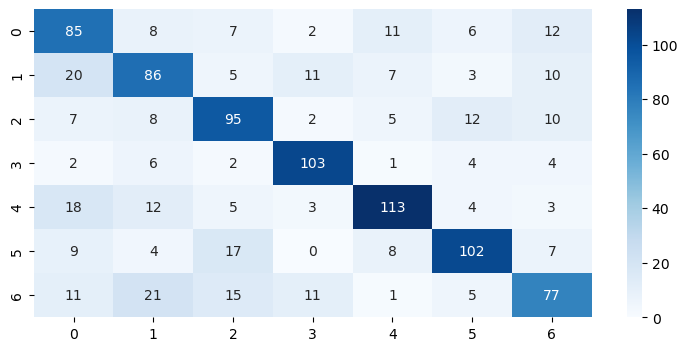

In [136]:
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [137]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.56      0.65      0.60       131
           1       0.59      0.61      0.60       142
           2       0.65      0.68      0.67       139
           3       0.78      0.84      0.81       122
           4       0.77      0.72      0.74       158
           5       0.75      0.69      0.72       147
           6       0.63      0.55      0.58       141

    accuracy                           0.67       980
   macro avg       0.68      0.68      0.68       980
weighted avg       0.68      0.67      0.67       980



y_test unique value :[0 1 2 3 4 5 6]


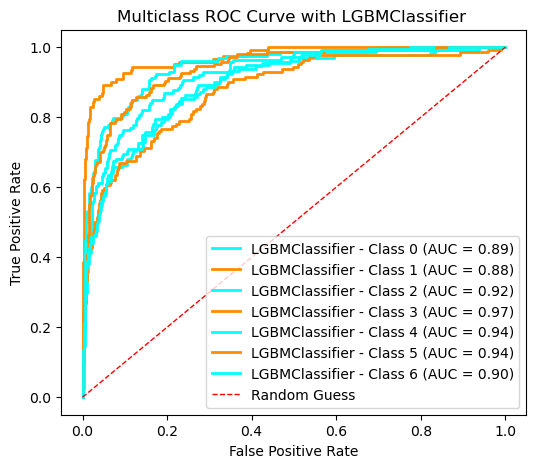

In [138]:
from plot.roc import plot_multi_roc

plot_multi_roc(X_test, y_test,lgbm_model)

<h2 style="color:blue;" >🚀 Xgbm</h2>

In [140]:
import xgboost as xgb
from xgboost import XGBClassifier

xgbm = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
print(f"Tree Method: {xgbm.get_params()['tree_method']}")

Tree Method: gpu_hist


In [141]:
xgbm.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [142]:
y_pred = xgbm.predict(X_test)

In [143]:
from eval.model_score import model_scoring
model_scoring(y_test,y_pred,results,'Xgbm',vectorization_method)

Xgbm | Word2Vec:
F1 Score 0.7106 | Accuracy:0.7112 | Precision:0.7112 | Recall:0.7112  
Results saved to eval/score.csv


<Axes: >

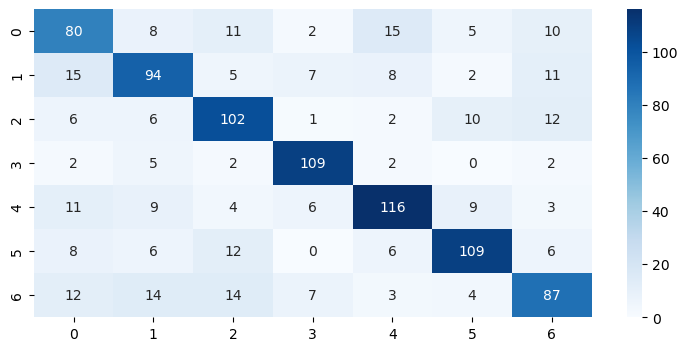

In [144]:
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [145]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.60      0.61      0.60       131
           1       0.66      0.66      0.66       142
           2       0.68      0.73      0.71       139
           3       0.83      0.89      0.86       122
           4       0.76      0.73      0.75       158
           5       0.78      0.74      0.76       147
           6       0.66      0.62      0.64       141

    accuracy                           0.71       980
   macro avg       0.71      0.71      0.71       980
weighted avg       0.71      0.71      0.71       980



y_test unique value :[0 1 2 3 4 5 6]


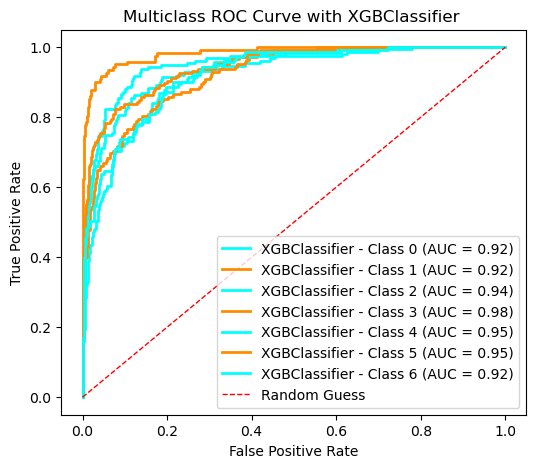

In [146]:
from plot.roc import plot_multi_roc

plot_multi_roc(X_test, y_test,xgbm)

<h2 style="color:blue;" >🚀 Naive Bayes </h2>

In [148]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()

In [149]:
naive_bayes.fit(X_train, y_train)

GaussianNB()

In [150]:
y_pred = naive_bayes.predict(X_test)

In [151]:
from eval.model_score import model_scoring
model_scoring(y_test,y_pred,results,'Naive Bayes',vectorization_method)

Naive Bayes | Word2Vec:
F1 Score 0.4891 | Accuracy:0.4959 | Precision:0.5150 | Recall:0.4959  
Results saved to eval/score.csv


<Axes: >

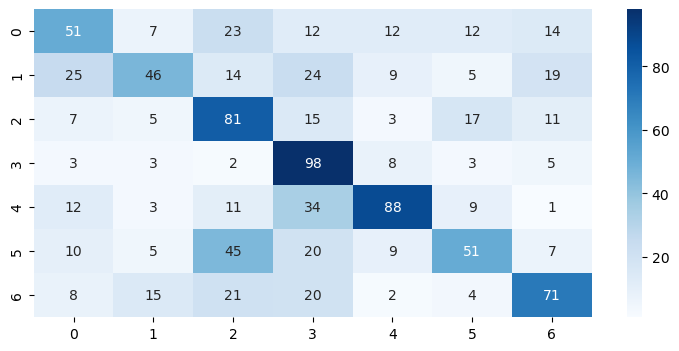

In [152]:
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [153]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.44      0.39      0.41       131
           1       0.55      0.32      0.41       142
           2       0.41      0.58      0.48       139
           3       0.44      0.80      0.57       122
           4       0.67      0.56      0.61       158
           5       0.50      0.35      0.41       147
           6       0.55      0.50      0.53       141

    accuracy                           0.50       980
   macro avg       0.51      0.50      0.49       980
weighted avg       0.51      0.50      0.49       980



y_test unique value :[0 1 2 3 4 5 6]


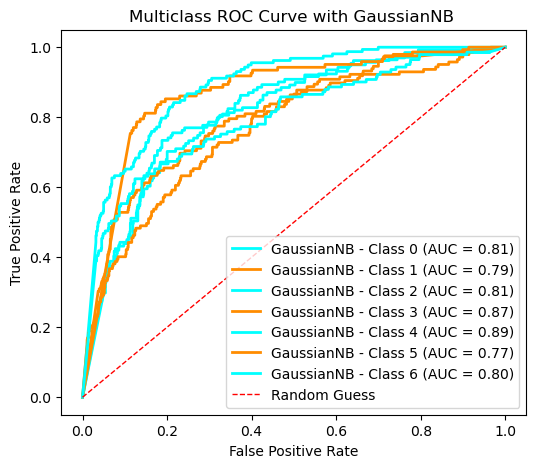

In [154]:
from plot.roc import plot_multi_roc

plot_multi_roc(X_test, y_test,naive_bayes)

<h2 style="color:blue;" >🚀 SVM RBF </h2>

In [156]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', random_state=42 ,probability=True)

In [157]:
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [158]:
y_pred= svm_model.predict(X_test)

In [159]:
from eval.model_score import model_scoring
model_scoring(y_test,y_pred,results,'SVM-RBF',vectorization_method)

SVM-RBF | Word2Vec:
F1 Score 0.5824 | Accuracy:0.5867 | Precision:0.5895 | Recall:0.5867  
Results saved to eval/score.csv


<Axes: >

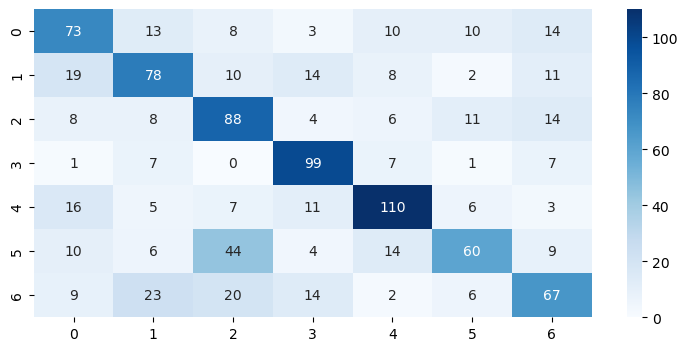

In [160]:
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [161]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.54      0.56      0.55       131
           1       0.56      0.55      0.55       142
           2       0.50      0.63      0.56       139
           3       0.66      0.81      0.73       122
           4       0.70      0.70      0.70       158
           5       0.62      0.41      0.49       147
           6       0.54      0.48      0.50       141

    accuracy                           0.59       980
   macro avg       0.59      0.59      0.58       980
weighted avg       0.59      0.59      0.58       980



y_test unique value :[0 1 2 3 4 5 6]


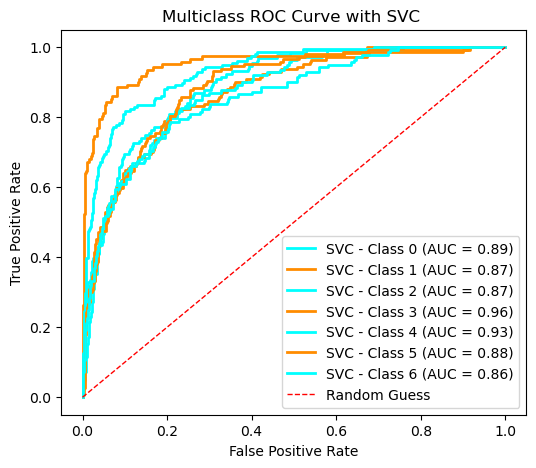

In [162]:
from plot.roc import plot_multi_roc

plot_multi_roc(X_test, y_test,svm_model)

<h2 style="color:olive;" >🚀 SimpleANN</h2>


In [164]:
# Hyperparameters for the simple ANN

input_dim = X_train.shape[1]; # 500
hidden_dim = 32
output_dim = len(set(labels))  # class numbers

LEARNING_RATE=0.001

num_epochs=50
BATCH_SIZE= 4

In [165]:
from nn_arch.simple_ann import SimpleANN
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

for i in range(torch.cuda.device_count()):
    print(f"device {i}: {torch.cuda.get_device_name(i)}\n")


simple_ann = SimpleANN(input_dim, hidden_dim, output_dim).to(device)
print(simple_ann)

#-----------

criterion = torch.nn.CrossEntropyLoss()  # loss func
optimizer = torch.optim.Adam(simple_ann.parameters(), lr=LEARNING_RATE)  # optimization alg

device: cuda
device 0: NVIDIA GeForce RTX 4060 Laptop GPU

SimpleANN(
  (fc1): Linear(in_features=500, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)


In [166]:
from torch.utils.data import DataLoader, TensorDataset


# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_label, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_label, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)



In [167]:
from nn_arch.nn_trainer import model_training

history, test, true = model_training(vectorization_method,
               simple_ann, criterion, optimizer,
               train_loader, val_loader,
               num_epochs = num_epochs)

Device: cuda
Epoch 1/50, Loss: 1.8332, Accuracy: 0.3161, Val Loss: 1.7417, Val Accuracy: 0.4092
Epoch 2/50, Loss: 1.7236, Accuracy: 0.4395, Val Loss: 1.7105, Val Accuracy: 0.4582
Epoch 3/50, Loss: 1.6865, Accuracy: 0.4719, Val Loss: 1.6966, Val Accuracy: 0.4684
Epoch 4/50, Loss: 1.6667, Accuracy: 0.4883, Val Loss: 1.6634, Val Accuracy: 0.4949
Epoch 5/50, Loss: 1.6630, Accuracy: 0.4890, Val Loss: 1.6531, Val Accuracy: 0.5153
Epoch 6/50, Loss: 1.6503, Accuracy: 0.5087, Val Loss: 1.6631, Val Accuracy: 0.4918
Epoch 7/50, Loss: 1.6490, Accuracy: 0.5097, Val Loss: 1.6589, Val Accuracy: 0.4959
Epoch 8/50, Loss: 1.6399, Accuracy: 0.5194, Val Loss: 1.6408, Val Accuracy: 0.5214
Epoch 9/50, Loss: 1.6354, Accuracy: 0.5222, Val Loss: 1.6296, Val Accuracy: 0.5347
Epoch 10/50, Loss: 1.6291, Accuracy: 0.5304, Val Loss: 1.6178, Val Accuracy: 0.5459
Epoch 11/50, Loss: 1.6264, Accuracy: 0.5344, Val Loss: 1.6306, Val Accuracy: 0.5306
Epoch 12/50, Loss: 1.6134, Accuracy: 0.5531, Val Loss: 1.5954, Val Accur

In [168]:
model_scoring(test, true ,results,simple_ann.__class__.__name__,vectorization_method)

SimpleANN | Word2Vec:
F1 Score 0.6035 | Accuracy:0.6051 | Precision:0.6216 | Recall:0.6051  
Results saved to eval/score.csv


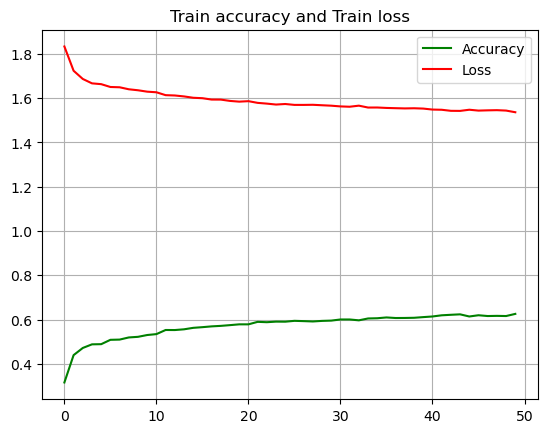

In [169]:
plt.plot(history["accuracy"],color="green")
plt.plot(history["loss"],color="red")
plt.title("Train accuracy and Train loss")
plt.legend(["Accuracy","Loss"])
plt.grid()

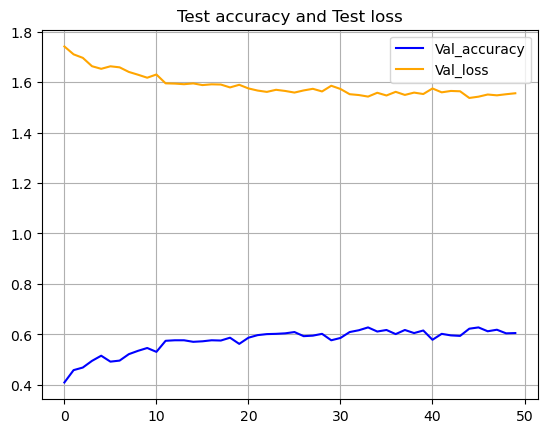

In [170]:
plt.plot(history["val_accuracy"],color="blue")
plt.plot(history["val_loss"],color="orange")
plt.title("Test accuracy and Test loss")
plt.legend(["Val_accuracy","Val_loss"])
plt.grid()


<Axes: >

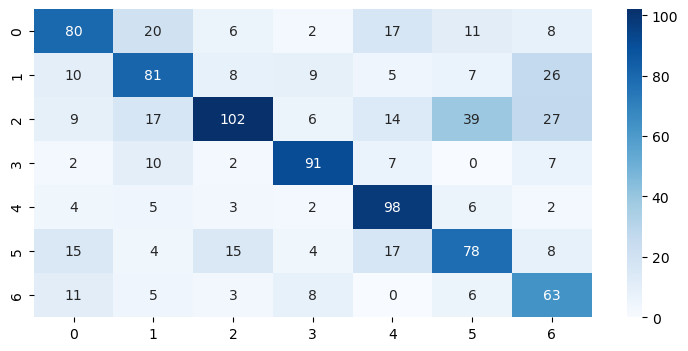

In [171]:
cm=confusion_matrix(test,true)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [172]:
print(classification_report(test, true)) 

              precision    recall  f1-score   support

           0       0.61      0.56      0.58       144
           1       0.57      0.55      0.56       146
           2       0.73      0.48      0.58       214
           3       0.75      0.76      0.76       119
           4       0.62      0.82      0.71       120
           5       0.53      0.55      0.54       141
           6       0.45      0.66      0.53        96

    accuracy                           0.61       980
   macro avg       0.61      0.63      0.61       980
weighted avg       0.62      0.61      0.60       980



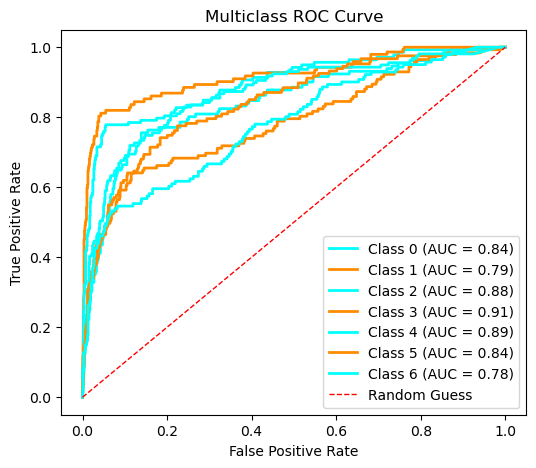

In [173]:
from plot.roc_NN import plot_multi_roc_NN

plot_multi_roc_NN(X_test, y_test,simple_ann,batch_size=BATCH_SIZE)

# results

In [175]:
show = pd.DataFrame.from_dict(results)

In [176]:
show

,Model,Vectorization Method,Accuracy,Precision,Recall,F1 Score
0,LightGBM,Bag Of Words,0.781633,0.780278,0.781633,0.779841
1,Xgbm,Bag Of Words,0.833673,0.834370,0.833673,0.833634
2,Naive Bayes,Bag Of Words,0.712245,0.728540,0.712245,0.706044
3,SVM-RBF,Bag Of Words,0.808163,0.808804,0.808163,0.807711
4,SimpleANN,Bag Of Words,0.835714,0.838245,0.835714,0.836045
5,LightGBM,TF_IDF,0.777551,0.776788,0.777551,0.775897
6,Xgbm,TF_IDF,0.825510,0.827294,0.825510,0.825669
7,Naive Bayes,TF_IDF,0.773469,0.776264,0.773469,0.769043
8,SVM-RBF,TF_IDF,0.856122,0.857023,0.856122,0.856408
9,SimpleANN,TF_IDF,0.829592,0.832747,0.829592,0.830563


In [177]:
import os
file_path = os.path.join('eval', 'checkpointeval.csv')
show.to_csv(file_path, index=False)

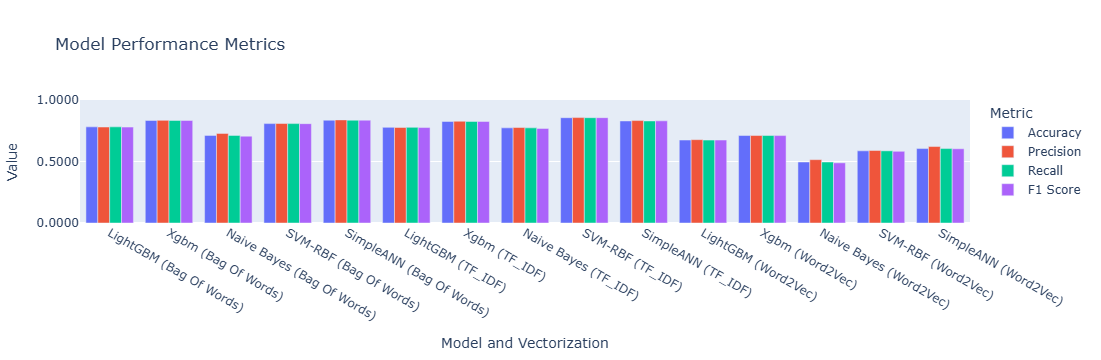

In [178]:
from plot.plotly import plotly_eval

plotly_eval(results)

<h1 style="color:crimson;" >BiLSTM Model</h1>

<h2 style="color:DeepSkyBlue;" >Preprocess for BiLSTM</h2>

###### In this phase, a more complex neural network architecture will be created. This architecture represents a type of ensemble learning structure.

###### In this structure, multiple different models are combined: (brief information)

##### CNN (Convolutional Neural Network): It is used especially to extract text or image features.
##### LSTM (Long Short-Term Memory): It is used to learn long contexts such as sequential data and time series.
##### BiLSTM (Bidirectional LSTM): It processes data both forward and backward.
##### GRU (Gated Recurrent Unit): It is similar to LSTM, but it is a lighter model.
###### Additionally, pre-trained word embeddings vectors created with Word2Vec will be used in this architecture and the model will also be trained with randomly initialized embedding vectors.

In [182]:
X=df_main.text.copy()

In [183]:
X.head()

0     3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1     mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2     disko lar kaldırılıyor başbakan_yardımcısı ar...
3     sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4     erdoğan idamın bir haklılık sebebi var demek ...
Name: text, dtype: object

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X_list, labels, test_size=0.2, random_state=42,shuffle=True)
print(len(X_train)) # 3920 sentences
print(len(y_train)) #3920 Labels
print(len(X_test))  # 980 sentences
print(len(y_test)) # 980 labels

3920
3920
980
980


In [185]:
y_train_label = np.asarray(y_train)  # Tek boyutlu olmalı
y_test_label = np.asarray(y_test)    #for ANN

In [186]:
import torch

print("Torch:", torch.__version__)
torch.cuda.is_available()
import torchtext.transforms as T
import torch
from collections import Counter
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence

import torch
from torchtext.vocab import vocab
print("Torch:", torch.__version__)
print("TorchText:", torchtext.__version__)


Torch: 2.3.0
Torch: 2.3.0
TorchText: 0.18.0+cpu


In [187]:
average_length = sum(len(x) for x in X_train) / len(X_train)
print(f"Ortalama uzunluk: {average_length}")

Ortalama uzunluk: 1843.6857142857143


In [188]:
# Maksimum length for padding
max_length = 100

# 1. Tokenization
def tokenize(text):
      return text.lower().split()

# 2. Building Vocabulary
tokenized_texts = [tokenize(text) for text in X_train]
word_counter = Counter(word for tokens in tokenized_texts for word in tokens)
vocab_dict = vocab(word_counter, specials=["<pad>", "<unk>"])
vocab_dict.set_default_index(vocab_dict["<unk>"])

# 3. Converting to Numerical Representation
def numericalize(tokens, vocab_dict):
    return torch.tensor([vocab_dict[token] for token in tokens], dtype=torch.long)

# 4. Padding Process
def pad_sequences(sequences, max_length, padding_value=0):
    padded = []
    for seq in sequences:
        if len(seq) < max_length:
            # Pad to the right
            padded.append(torch.cat([seq, torch.full((max_length - len(seq),), padding_value)]))
        else:
            # Truncate if longer than max_length
            padded.append(seq[:max_length])
    return torch.stack(padded)


In [189]:
# Word Dictionary (word_index)
word_index = {word: idx for idx, word in enumerate(vocab_dict.get_itos())}
numericalized_texts = [numericalize(tokens, vocab_dict) for tokens in tokenized_texts]
X_train_padded = pad_sequences(numericalized_texts, max_length, padding_value=vocab_dict["<pad>"])

# 5. Review Outputs
print("Kelime Sayısı (word_index):", len(word_index))
print("Padded Eğitim Verisi Boyutu:", X_train_padded.shape)

Kelime Sayısı (word_index): 94645
Padded Eğitim Verisi Boyutu: torch.Size([3920, 100])


In [190]:
print("Original Version Frist 100:",X_train[0][:100])
print("---------------------------------")
print("Padded version",X_train_padded[0]) 
print("---------------------------------")
print("Tokenized version:",numericalized_texts[0])  # change words with number that corresponding to word word_index
print("---------------------------------")
print("Shape after the padding:",X_train_padded.shape) # make our input same size

Original Version Frist 100: internet e plorer un son versiyonu hazırlanıyor microsoft internet e plorer tarayıcısının son sürümü
---------------------------------
Padded version tensor([ 2,  3,  4,  5,  6,  7,  8,  9,  2,  3,  4, 10,  6, 11, 12, 13, 14, 15,
        16,  6, 17, 18,  9, 19, 20, 21, 14, 22, 23, 24, 25, 26, 27, 28,  2,  3,
         4, 29, 30, 31, 26, 27, 22, 32, 33, 34, 35, 36, 37,  2,  3,  4,  5, 38,
        11, 39, 40,  2,  3,  4,  5,  6, 41, 26, 27, 42, 43, 44, 45, 46,  6, 47,
        34, 48, 49, 50, 26, 27,  3, 51, 52, 53, 54, 55,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
---------------------------------
Tokenized version: tensor([ 2,  3,  4,  5,  6,  7,  8,  9,  2,  3,  4, 10,  6, 11, 12, 13, 14, 15,
        16,  6, 17, 18,  9, 19, 20, 21, 14, 22, 23, 24, 25, 26, 27, 28,  2,  3,
         4, 29, 30, 31, 26, 27, 22, 32, 33, 34, 35, 36, 37,  2,  3,  4,  5, 38,
        11, 39, 40,  2,  3,  4,  5,  6, 41, 26, 27, 42, 43, 44, 45, 46,  6, 47,


In [191]:
# 1. Tokenization
tokenized_texts_test = [tokenize(text) for text in X_test]

# 2. Converting to Numerical Representation
numericalized_texts_test = [numericalize(tokens, vocab_dict) for tokens in tokenized_texts_test]

# 3. Padding Process
X_test_padded = pad_sequences(numericalized_texts_test, max_length, padding_value=vocab_dict["<pad>"])

# 4. Review Outputs
print("Kelime Sayısı (word_index):", len(word_index))
print("Padded Test Verisi Boyutu:", X_test_padded.shape)

Kelime Sayısı (word_index): 94645
Padded Test Verisi Boyutu: torch.Size([980, 100])


<h2 style="color:ForestGreen;"> DataLoader</h2>

In [193]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE= 8

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_label, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_label, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


<h2 style="color:Coral;" >🚀 ComplexANN</h2>
<p >  Model traning for LSTM ANN</p>

<p>After a few tries in 10 epochs, I saw that the most logical one was embeding+bilstm, but since there was a combination in the request, I obtained a combination using embeding+CNN+bilstm, the other ones I tried:</p>
<p>embeding+cnn+bisltm+lstm usage, emdedding+cnn+bisltm+lstm+gru emdedding+lstm I saw that the success of emdedding+cnn+lstm was low.</p>

<p>Hyperparameters for the complex ANN<p>

In [197]:
vocab_size =  len(vocab_dict);output_dim = len(set(labels))
print(vocab_size)# Total number of unique words in your vocabulary
print(output_dim)# Number of output classes (e.g., for classification)


embedding_dim = 128  # Dimensionality of word embeddings
hidden_dim = 64  # Hidden dimension size 
cnn_filters = 128  # Number of CNN filters
kernel_size = 3  # Size of the convolutional kernel
embedding_matrix = None  # Pretrained embeddings, if any
LEARNING_RATE=0.01
num_epochs=10


94645
7


In [198]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

from nn_arch.complex_ann import ComplexANN

complex_ann = ComplexANN(vocab_size, embedding_dim,output_dim).to(device)

print(complex_ann)

criterion = torch.nn.CrossEntropyLoss()  # loss func
optimizer = torch.optim.Adam(complex_ann.parameters(), lr=LEARNING_RATE)  # optimization alg

Device: cuda
ComplexANN(
  (embedding): Embedding(94645, 128)
  (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu_cnn): ReLU()
  (batch_norm_cnn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bilstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=64, bias=True)
  (relu): ReLU()
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)


In [199]:
total_params = sum(p.numel() for p in complex_ann.parameters())
print(f"model sum parameters: {total_params}")

model sum parameters: 12673927


In [200]:
from nn_arch.nn_trainer import model_training

history, test, true = model_training('padding',
               complex_ann, criterion, optimizer,
               train_loader, val_loader,
               num_epochs = 50)

Device: cuda
Epoch 1/50, Loss: 1.7971, Accuracy: 0.3472, Val Loss: 1.6557, Val Accuracy: 0.5020
Epoch 2/50, Loss: 1.6316, Accuracy: 0.5273, Val Loss: 1.5616, Val Accuracy: 0.5929
Epoch 3/50, Loss: 1.5563, Accuracy: 0.6066, Val Loss: 1.5111, Val Accuracy: 0.6551
Epoch 4/50, Loss: 1.5014, Accuracy: 0.6579, Val Loss: 1.4773, Val Accuracy: 0.6867
Epoch 5/50, Loss: 1.4762, Accuracy: 0.6852, Val Loss: 1.4800, Val Accuracy: 0.6857
Epoch 6/50, Loss: 1.4574, Accuracy: 0.7036, Val Loss: 1.4633, Val Accuracy: 0.6990
Epoch 7/50, Loss: 1.4377, Accuracy: 0.7242, Val Loss: 1.4742, Val Accuracy: 0.6888
Epoch 8/50, Loss: 1.4330, Accuracy: 0.7301, Val Loss: 1.4534, Val Accuracy: 0.7122
Epoch 9/50, Loss: 1.4258, Accuracy: 0.7378, Val Loss: 1.4421, Val Accuracy: 0.7163
Epoch 10/50, Loss: 1.4094, Accuracy: 0.7543, Val Loss: 1.4044, Val Accuracy: 0.7602
Epoch 11/50, Loss: 1.3894, Accuracy: 0.7740, Val Loss: 1.4611, Val Accuracy: 0.6990
Epoch 12/50, Loss: 1.3783, Accuracy: 0.7855, Val Loss: 1.4004, Val Accur

In [201]:
from eval.model_score import model_scoring

model_scoring(test, true ,results, complex_ann.__class__.__name__, "padding")

ComplexANN | padding:
F1 Score 0.7201 | Accuracy:0.7214 | Precision:0.7334 | Recall:0.7214  
Results saved to eval/score.csv


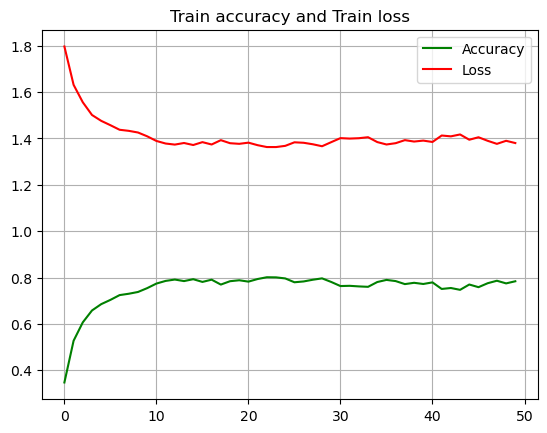

In [202]:
plt.plot(history["accuracy"],color="green")
plt.plot(history["loss"],color="red")
plt.title("Train accuracy and Train loss")
plt.legend(["Accuracy","Loss"])
plt.grid()

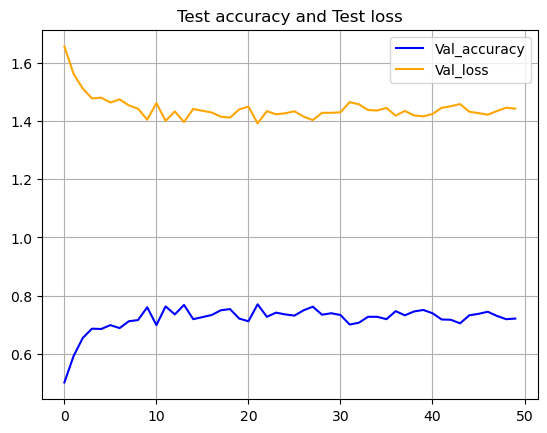

In [203]:
plt.plot(history["val_accuracy"],color="blue")
plt.plot(history["val_loss"],color="orange")
plt.title("Test accuracy and Test loss")
plt.legend(["Val_accuracy","Val_loss"])
plt.grid()


<Axes: >

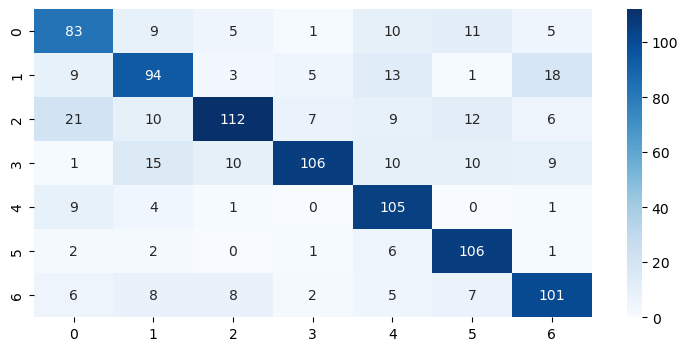

In [204]:
cm=confusion_matrix(test,true)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [205]:
print(classification_report(test, true)) 

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       124
           1       0.66      0.66      0.66       143
           2       0.81      0.63      0.71       177
           3       0.87      0.66      0.75       161
           4       0.66      0.88      0.76       120
           5       0.72      0.90      0.80       118
           6       0.72      0.74      0.73       137

    accuracy                           0.72       980
   macro avg       0.72      0.73      0.72       980
weighted avg       0.73      0.72      0.72       980



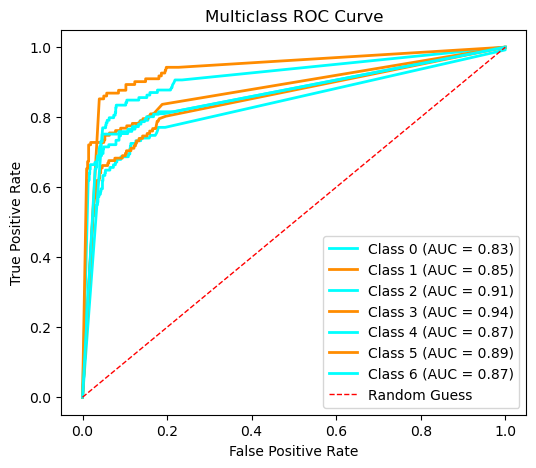

In [206]:
from plot.roc_NN import plot_multi_roc_NN

plot_multi_roc_NN(X_test_padded, y_test_label,complex_ann,batch_size=BATCH_SIZE,torch_type="long")

<h2 style="color:Coral;" >ComplexANN with finetune trmodel embedding layer </h2>
<p style="color:CornflowerBlue;" >I will use loader ramdom embedding layer version (first fit complexANN/bilstm)</p>                          

<p>Hyperparameters for the complex ANN<p>

In [209]:
vocab_size =  len(vocab_dict);output_dim = len(set(labels))
print(vocab_size)# Total number of unique words in your vocabulary
print(output_dim)# Number of output classes (e.g., for classification)


embedding_dim = 128  # Dimensionality of word embeddings
hidden_dim = 64  # Hidden dimension size 
cnn_filters = 128  # Number of CNN filters
kernel_size = 3  # Size of the convolutional kernel
embedding_matrix = None  # Pretrained embeddings, if any
LEARNING_RATE=0.01
num_epochs=10


94645
7


In [210]:
import os
from gensim.models import KeyedVectors
# Load the Word2Vec model
current_dir = os.getcwd()
model_path = os.path.join(current_dir, 'finetunetrmodel/trmodel_finetune.kv')

In [211]:
keyed_vectors = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [212]:
import numpy as np
# Extract vocabulary size and embedding dimensions
vocab_size = len(keyed_vectors) # Number of words in the vocabulary
print(f"Vocabulary size: {vocab_size}")
embedding_dim = keyed_vectors.vector_size  # Dimension of word vectors
print(f"Embedding dimension: {embedding_dim}")


# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Create a word-to-index mapping
word_to_index = {word: idx for idx, word in enumerate(keyed_vectors.index_to_key)}

# Populate the embedding matrix
for word, idx in word_to_index.items():
    embedding_matrix[idx] = keyed_vectors[word]
    
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Vocabulary size: 442423
Embedding dimension: 400
Embedding matrix shape: (442423, 400)


In [213]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

from nn_arch.complex_ann import ComplexANN

complex_ann_trmodel = ComplexANN(vocab_size, embedding_dim, output_dim,input_length=100, hidden_dim=64,
                                 cnn_filters=128, kernel_size=3, pretrained_embedding = embedding_matrix).to(device)
print(complex_ann_trmodel)

criterion = torch.nn.CrossEntropyLoss()  # loss function
optimizer = torch.optim.Adam(complex_ann_trmodel.parameters(), lr=LEARNING_RATE)  # optimization alg

Device: cuda
ComplexANN(
  (embedding): Embedding(442423, 400)
  (conv1): Conv1d(400, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu_cnn): ReLU()
  (batch_norm_cnn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bilstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=64, bias=True)
  (relu): ReLU()
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)


In [214]:
total_params = sum(p.numel() for p in complex_ann_trmodel.parameters())
print(f"model sum parameters: {total_params}")

model sum parameters: 177633015


In [215]:
from nn_arch.nn_trainer import model_training

history, test, true = model_training('Finetunetrmodel',
               complex_ann_trmodel, criterion, optimizer,
               train_loader, val_loader,
               num_epochs = 50)

Device: cuda
Epoch 1/50, Loss: 1.8226, Accuracy: 0.3204, Val Loss: 1.7166, Val Accuracy: 0.4388
Epoch 2/50, Loss: 1.6773, Accuracy: 0.4809, Val Loss: 1.6573, Val Accuracy: 0.4929
Epoch 3/50, Loss: 1.6342, Accuracy: 0.5209, Val Loss: 1.6140, Val Accuracy: 0.5388
Epoch 4/50, Loss: 1.5781, Accuracy: 0.5791, Val Loss: 1.5858, Val Accuracy: 0.5857
Epoch 5/50, Loss: 1.5408, Accuracy: 0.6207, Val Loss: 1.6024, Val Accuracy: 0.5510
Epoch 6/50, Loss: 1.5508, Accuracy: 0.6079, Val Loss: 1.6064, Val Accuracy: 0.5551
Epoch 7/50, Loss: 1.5116, Accuracy: 0.6518, Val Loss: 1.5565, Val Accuracy: 0.5980
Epoch 8/50, Loss: 1.4560, Accuracy: 0.7069, Val Loss: 1.5027, Val Accuracy: 0.6541
Epoch 9/50, Loss: 1.4304, Accuracy: 0.7298, Val Loss: 1.5206, Val Accuracy: 0.6398
Epoch 10/50, Loss: 1.4264, Accuracy: 0.7367, Val Loss: 1.5058, Val Accuracy: 0.6500
Epoch 11/50, Loss: 1.4123, Accuracy: 0.7515, Val Loss: 1.4902, Val Accuracy: 0.6745
Epoch 12/50, Loss: 1.4039, Accuracy: 0.7587, Val Loss: 1.4862, Val Accur

In [216]:
from eval.model_score import model_scoring

model_scoring(test, true ,results, complex_ann_trmodel.__class__.__name__, "Finetunetrmodel")

ComplexANN | Finetunetrmodel:
F1 Score 0.7250 | Accuracy:0.7224 | Precision:0.7397 | Recall:0.7224  
Results saved to eval/score.csv


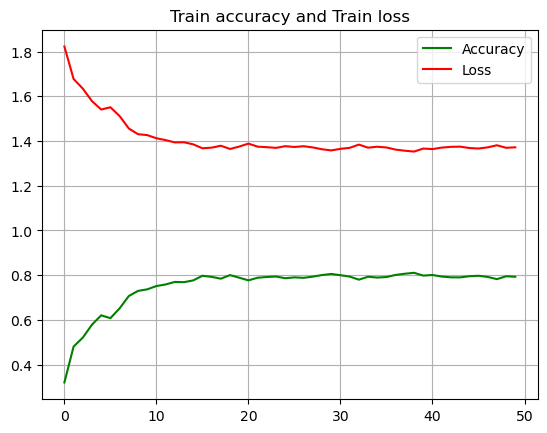

In [217]:
plt.plot(history["accuracy"],color="green")
plt.plot(history["loss"],color="red")
plt.title("Train accuracy and Train loss")
plt.legend(["Accuracy","Loss"])
plt.grid()

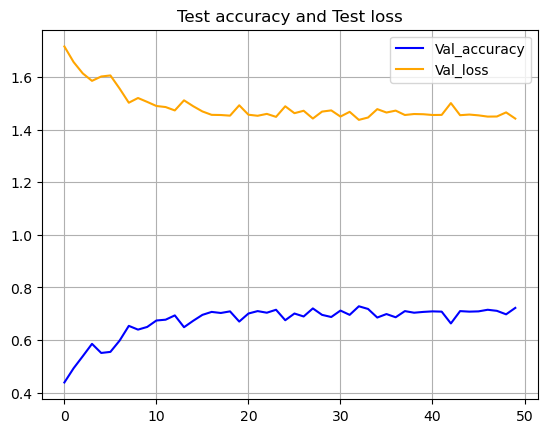

In [218]:
plt.plot(history["val_accuracy"],color="blue")
plt.plot(history["val_loss"],color="orange")
plt.title("Test accuracy and Test loss")
plt.legend(["Val_accuracy","Val_loss"])
plt.grid()


<Axes: >

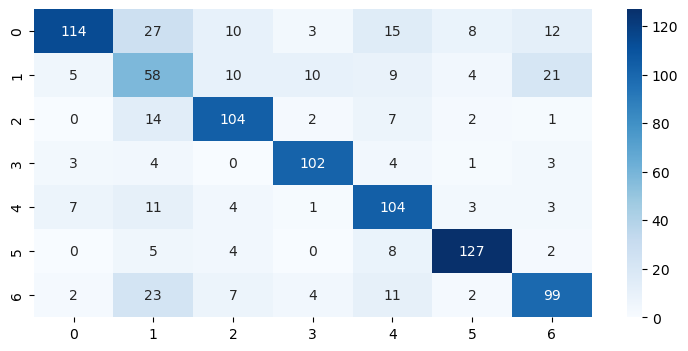

In [219]:
cm=confusion_matrix(test,true)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [220]:
print(classification_report(test, true)) 

              precision    recall  f1-score   support

           0       0.87      0.60      0.71       189
           1       0.41      0.50      0.45       117
           2       0.75      0.80      0.77       130
           3       0.84      0.87      0.85       117
           4       0.66      0.78      0.71       133
           5       0.86      0.87      0.87       146
           6       0.70      0.67      0.69       148

    accuracy                           0.72       980
   macro avg       0.73      0.73      0.72       980
weighted avg       0.74      0.72      0.72       980



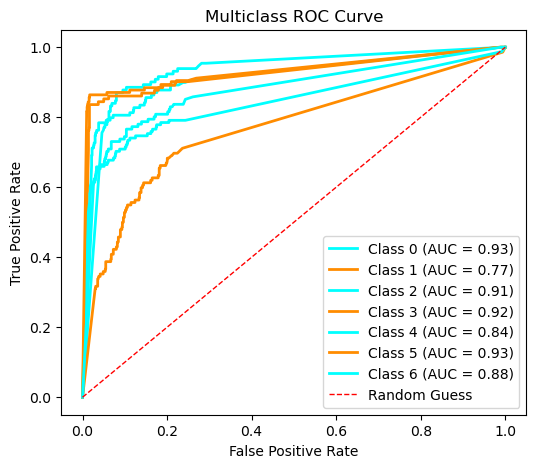

In [221]:
from plot.roc_NN import plot_multi_roc_NN

plot_multi_roc_NN(X_test_padded, y_test_label,
                  complex_ann_trmodel,batch_size=BATCH_SIZE,
                  torch_type="long")

# results

In [223]:
last_two_results = {key: value[-2:] for key, value in results.items()}

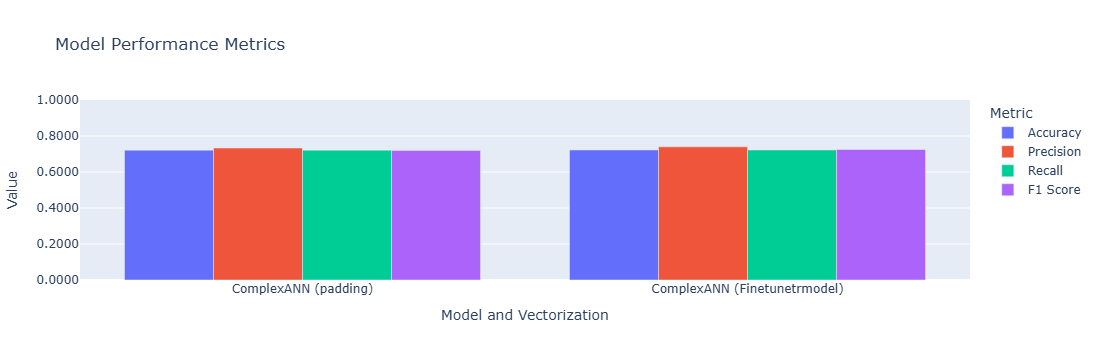

In [224]:
from plot.plotly import plotly_eval

plotly_eval(last_two_results)

<h1 style="color:blue;" >🚀 BERT </h1>


In [226]:
%%capture
!pip install simpletransformers
print("simpletransformers done.")

## split 

In [228]:
X = df_main.text.copy()
y = labels
df_split = pd.concat([X,y],axis = 1)

In [229]:
df_train,df_test = train_test_split(df_split,test_size=0.2,random_state=42)
print("df_train",df_train.shape)
print("df_test",df_test.shape)

df_train (3920, 2)
df_test (980, 2)


## savasy/bert-turkish-text-classification

In [231]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer, AutoModelForSequenceClassification
tokenizer= AutoTokenizer.from_pretrained("savasy/bert-turkish-text-classification")

# build and load model, it take time depending on your internet connection
model= AutoModelForSequenceClassification.from_pretrained("savasy/bert-turkish-text-classification")

# make pipeline
nlp=pipeline("sentiment-analysis", model=model, tokenizer=tokenizer,truncation=True)

# apply model
q = nlp("bla bla")
print(q)

Device set to use cuda:0


[{'label': 'culture', 'score': 0.47530055046081543}]


In [232]:
num_labels = model.config.num_labels
print(f"Number of Classes: {num_labels}")
# get label's name
label_map = model.config.id2label
print("Class Names:")
for label_id, label_name in label_map.items():
    print(f"{label_id}: {label_name}")

Number of Classes: 7
Class Names:
0: world
1: economy
2: culture
3: health
4: politics
5: sport
6: technology


In [233]:
label_to_encode={'world': 0,'economy': 1,'culture': 2,
                 'health': 3,'politics': 4,'sport': 5,'technology': 6}

label_to_encode[nlp("bla bla")[0]['label']]

2

In [234]:
# make pred
pred = []

for text in df_test["text"].tolist():
    label = label_to_encode[nlp(text)[0]['label']]
    pred.append(label)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [235]:
from eval.model_score import model_scoring

model_scoring(df_test["category"],pred,results,'Bert-savasy',"text-class")

Bert-savasy | text-class:
F1 Score 0.9581 | Accuracy:0.9582 | Precision:0.9587 | Recall:0.9582  
Results saved to eval/score.csv


<Axes: >

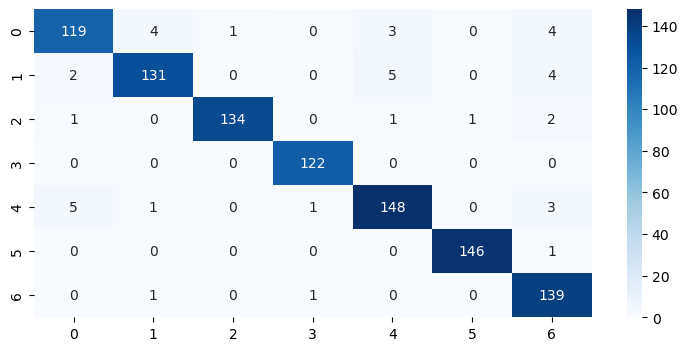

In [236]:
cm=confusion_matrix(df_test["category"],pred)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [237]:
# Batch 
batch_size = 4


raw_outputs = []


for i in range(0, len(df_test["text"]), batch_size):
    batch_texts = df_test["text"].iloc[i:i + batch_size].tolist() 
    
    # tokenize 
    inputs = tokenizer(batch_texts, truncation=True, padding=True, return_tensors="pt")
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
    
    # make pred with model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get logits values ​​and add to list
    logits = outputs.logits.cpu().numpy()
    raw_outputs.append(logits)

# Merge all batch results
raw_outputs = np.concatenate(raw_outputs, axis=0)
print(raw_outputs[56])

[ 5.0997124  -0.35045782 -1.4193473  -2.2009747   2.7726688  -2.0175195
 -2.0429447 ]


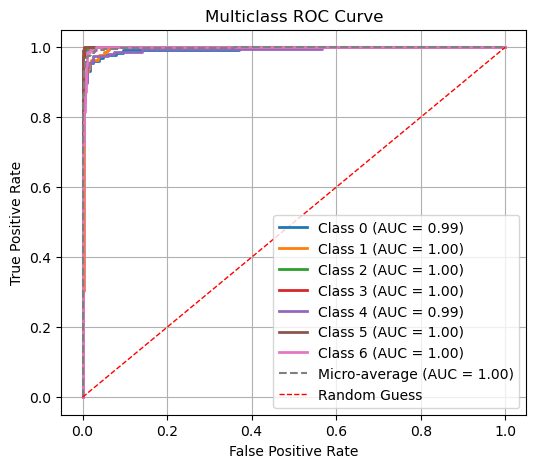

In [238]:
from plot.rocBert import plot_multi_roc_bert
 
# ROC-AUC graph and scores
roc_auc_scores = plot_multi_roc_bert(df_test["category"], np.array(raw_outputs), 7)

## Bert turkish finetune

In [240]:
from simpletransformers.classification import ClassificationModel
import torch,sklearn

model_args = {
    "use_early_stopping": True,
    "early_stopping_delta": 0.01,
    "early_stopping_metric": "mcc",
    "early_stopping_metric_minimize": False,
    "early_stopping_patience": 5,
    "evaluate_during_training_steps": 1000,
    "fp16": False,
    "num_train_epochs":3
}

cuda_available = torch.cuda.is_available()

model = ClassificationModel(
    "bert", 
    "dbmdz/bert-base-turkish-cased",
     use_cuda=cuda_available, 
     args=model_args, 
     num_labels=7
)
model.train_model(df_train, acc=sklearn.metrics.accuracy_score)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/490 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/490 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/490 [00:00<?, ?it/s]

(1470, 0.29440816313600116)

In [241]:
predictions, raw_outputs = model.predict(df_test["text"].tolist())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [242]:
# print pred and score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df_test["category"], predictions)
print(f"Prediction Accuracy: {accuracy}")
print(f"True Labels: {df_test['category'].sample(10,random_state=42).tolist()}")
predictions_df = pd.DataFrame(predictions, columns=["Predictions"])
print(f"Predict Labels: {predictions_df["Predictions"].sample(10,random_state=42).tolist()}")

Prediction Accuracy: 0.9255102040816326
True Labels: [0, 5, 6, 3, 4, 5, 2, 0, 6, 3]
Predict Labels: [0, 5, 6, 3, 0, 5, 2, 0, 6, 3]


In [243]:
from eval.model_score import model_scoring
model_scoring(df_test["category"],predictions,results,'Bert-tr',"finetune")

Bert-tr | finetune:
F1 Score 0.9253 | Accuracy:0.9255 | Precision:0.9259 | Recall:0.9255  
Results saved to eval/score.csv


<Axes: >

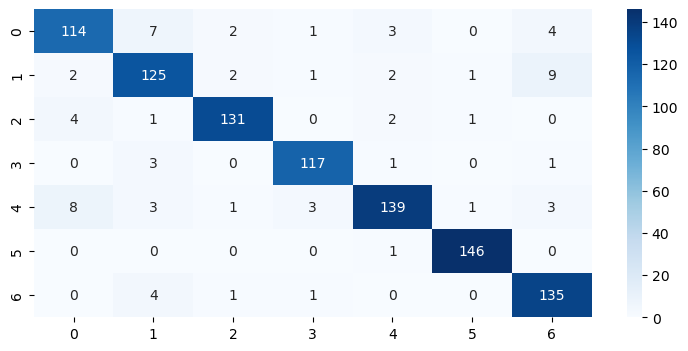

In [244]:
cm=confusion_matrix(df_test["category"],predictions)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [245]:
print(classification_report(df_test["category"], predictions)) 

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       131
           1       0.87      0.88      0.88       142
           2       0.96      0.94      0.95       139
           3       0.95      0.96      0.96       122
           4       0.94      0.88      0.91       158
           5       0.98      0.99      0.99       147
           6       0.89      0.96      0.92       141

    accuracy                           0.93       980
   macro avg       0.93      0.93      0.93       980
weighted avg       0.93      0.93      0.93       980



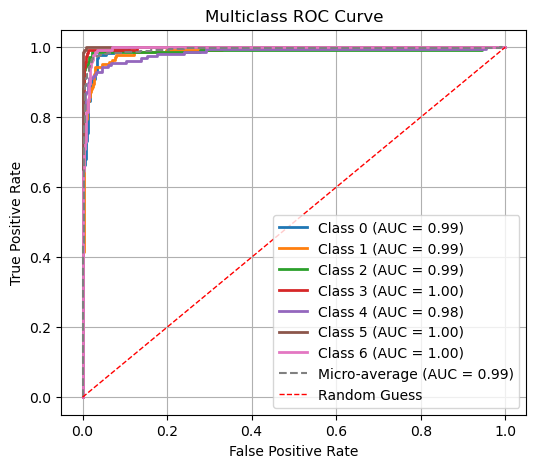

In [246]:
from plot.rocBert import plot_multi_roc_bert
 
# ROC-AUC graph and scores
roc_auc_scores = plot_multi_roc_bert(df_test["category"], np.array(raw_outputs), 7)

In [247]:
# Her sınıf için AUC skorlarını yazdırma
for cls, auc_score in roc_auc_scores.items():
    print(f"Class {cls} AUC: {auc_score:.4f}")

Class 0 AUC: 0.9927
Class 1 AUC: 0.9888
Class 2 AUC: 0.9901
Class 3 AUC: 0.9980
Class 4 AUC: 0.9841
Class 5 AUC: 0.9998
Class 6 AUC: 0.9951


## Bert multilingual finetune

In [249]:
model = ClassificationModel('bert', 'bert-base-multilingual-uncased', num_labels=7, 
                            args={'reprocess_input_data': True, 'overwrite_output_dir': True, 'num_train_epochs': 3})

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [250]:
# Now lets fine tune bert with the train set
model.train_model(df_train)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/490 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/490 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/490 [00:00<?, ?it/s]

(1470, 0.42235153483695725)

In [251]:
predictions, raw_outputs = model.predict(df_test["text"].tolist())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [252]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df_test["category"], predictions)
print(f"Prediction Accuracy: {accuracy}")
print(f"True Labels: {df_test['category'].sample(10,random_state=42).tolist()}")
predictions_df = pd.DataFrame(predictions, columns=["Predictions"])
print(f"Predict Labels: {predictions_df["Predictions"].sample(10,random_state=42).tolist()}")

Prediction Accuracy: 0.9173469387755102
True Labels: [0, 5, 6, 3, 4, 5, 2, 0, 6, 3]
Predict Labels: [0, 5, 6, 3, 4, 5, 2, 0, 6, 3]


In [253]:
from eval.model_score import model_scoring
model_scoring(df_test["category"],predictions,results,'Bert-multilingual',"finetune")

Bert-multilingual | finetune:
F1 Score 0.9170 | Accuracy:0.9173 | Precision:0.9179 | Recall:0.9173  
Results saved to eval/score.csv


<Axes: >

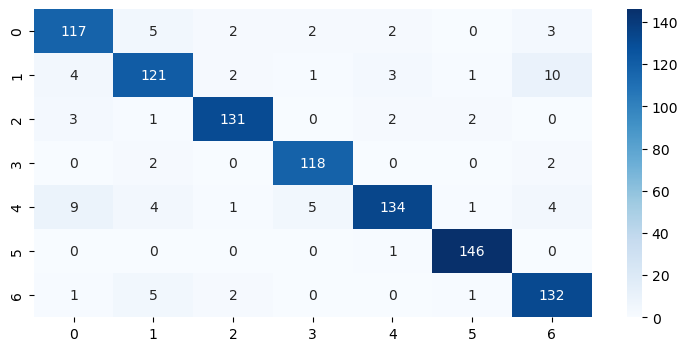

In [254]:
cm=confusion_matrix(df_test["category"],predictions)

plt.figure(figsize=(9,4))
sns.heatmap(cm, cmap="Blues",annot=True,fmt='d')

In [255]:
print(classification_report(df_test["category"], predictions)) 

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       131
           1       0.88      0.85      0.86       142
           2       0.95      0.94      0.95       139
           3       0.94      0.97      0.95       122
           4       0.94      0.85      0.89       158
           5       0.97      0.99      0.98       147
           6       0.87      0.94      0.90       141

    accuracy                           0.92       980
   macro avg       0.92      0.92      0.92       980
weighted avg       0.92      0.92      0.92       980



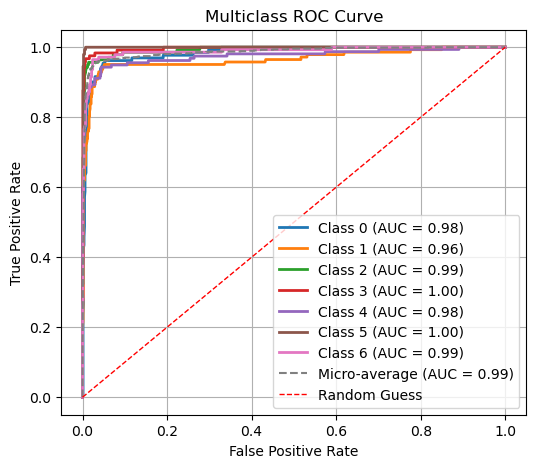

In [256]:
from plot.rocBert import plot_multi_roc_bert
 
# ROC-AUC graph and scores
roc_auc_scores = plot_multi_roc_bert(df_test["category"], np.array(raw_outputs), 7)

In [257]:
#print auc score for each class
for cls, auc_score in roc_auc_scores.items():
    print(f"Class {cls} AUC: {auc_score:.4f}")

Class 0 AUC: 0.9837
Class 1 AUC: 0.9647
Class 2 AUC: 0.9929
Class 3 AUC: 0.9964
Class 4 AUC: 0.9754
Class 5 AUC: 0.9991
Class 6 AUC: 0.9883


# Results

In [259]:
scores = pd.DataFrame(results)

In [260]:
scores

,Model,Vectorization Method,Accuracy,Precision,Recall,F1 Score
0,LightGBM,Bag Of Words,0.781633,0.780278,0.781633,0.779841
1,Xgbm,Bag Of Words,0.833673,0.834370,0.833673,0.833634
2,Naive Bayes,Bag Of Words,0.712245,0.728540,0.712245,0.706044
3,SVM-RBF,Bag Of Words,0.808163,0.808804,0.808163,0.807711
4,SimpleANN,Bag Of Words,0.835714,0.838245,0.835714,0.836045
5,LightGBM,TF_IDF,0.777551,0.776788,0.777551,0.775897
6,Xgbm,TF_IDF,0.825510,0.827294,0.825510,0.825669
7,Naive Bayes,TF_IDF,0.773469,0.776264,0.773469,0.769043
8,SVM-RBF,TF_IDF,0.856122,0.857023,0.856122,0.856408
9,SimpleANN,TF_IDF,0.829592,0.832747,0.829592,0.830563


In [261]:
import os
file_path = os.path.join('eval', 'eval.csv')
scores.to_csv(file_path, index=False)

$ pip install -U kaleido

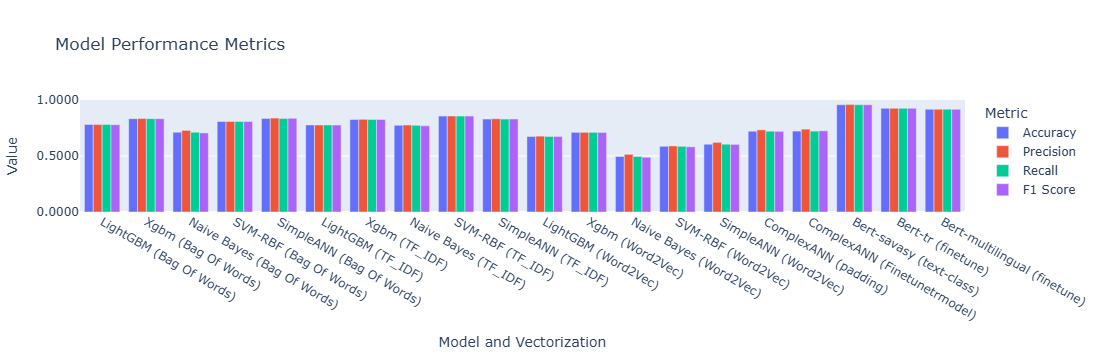

In [263]:
from plot.plotly import plotly_eval

plotly_eval(results)

## 🏆 Best Scores for Pre-trained Models and Fine-tuning

### 🔹 Pre-trained Model Fine-tuned with 7allV03:
**Model:** Bert-savasy   
- 🟢 **Precision:** 0.958747 | **Recall:** 0.958163 | **F1-score:** 0.958163 | **Accuracy:** 0.958116  

---

### 🔹 Pre-trained Model (Turkish Bert) my Fine-tuned with 7allV03:
**Model:** Bert-tr   
- 🟡 **Precision:** 0.925940 | **Recall:** 0.925510 | **F1-score:** 0.925348 | **Accuracy:** 0.925510  

---

### 🔹 Pre-trained Model (Multilingual Bert) my Fine-tuned with 7allV03:
**Model:** Bert-multilingual  
- 🟠 **Precision:** 0.917939 | **Recall:** 0.917347 | **F1-score:** 0.916980 | **Accuracy:** 0.917347  

---

## ⭐ Best Performing Models (Non-Pretrained)

### 🔸 SVM with RBF Kernel:
**Vectorization Method:** TF-IDF  
- 🔵 **Precision:** 0.857023 | **Recall:** 0.856122 | **F1-score:** 0.856408 | **Accuracy:** 0.856122  

---

### 🔸 Simple Artificial Neural Network (ANN):
**Vectorization Method:** TF-IDF  
- 🟠 **Precision:** 0.832747 | **Recall:** 0.829592 | **F1-score:** 0.830563 | **Accuracy:** 0.829592  

---

### 🔸 XGBM:
**Vectorization Method:** Bag of Words  
- 🟡 **Precision:** 0.834370 | **Recall:** 0.833673 | **F1-score:** 0.833634 | **Accuracy:** 0.833673  

---

### 🔸 Complex ANN:
**Vectorization Method:** Finetunetrmodel  
- 🟢 **Precision:** 0.739738 | **Recall:** 0.722449 | **F1-score:** 0.724980 | **Accuracy:** 0.722449  


# note

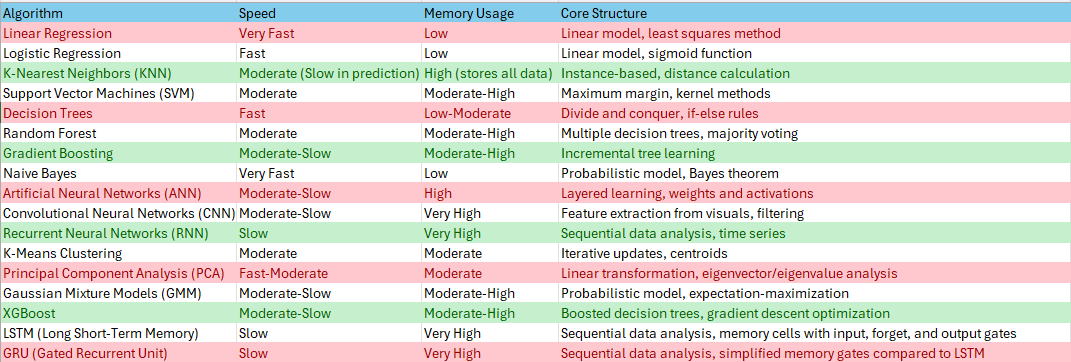